# Проект "Промышленность"

### Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.    
**Наша задача** — построить модель, которая будет её предсказывать.
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.     
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).    
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.    
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

### Описание данны

Данные состоят из нескольких файлов, полученных из разных источников:
* **data_arc_new.csv** — данные об электродах;
  * *key* — номер партии;
  * *Начало нагрева дугой* — время начала нагрева;
  * *Конец нагрева дугой* — время окончания нагрева;
  * *Активная мощность* — значение активной мощности;
  * *Реактивная мощность* — значение реактивной мощности.
* **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
  * *key* — номер партии;
  * *Bulk 1 … Bulk 15* — объём подаваемого материала.
* **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
  * *key* — номер партии;
  * *Bulk 1 … Bulk 15* — время подачи материала.
* **data_gas_new.csv** — данные о продувке сплава газом;
  * *key* — номер партии;
  * *Газ 1* — объём подаваемого газа.
* **data_temp_new.csv** — результаты измерения температуры;
  * *key* — номер партии;
  * *Время замера* — время замера;
  * *Температура* — значение температуры.
* **data_wire_new.csv** — данные о проволочных материалах (объём);
  * *key* — номер партии;
  * *Wire 1 … Wire 9* — объём подаваемых проволочных материалов.
* **data_wire_time_new.csv** — данные о проволочных материалах (время);
  * *key* — номер партии;
  * *Wire 1 … Wire 9* — время подачи проволочных материалов.
    
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### План работы

* 1. **Загрузка и исследовательский анализ данных:**  
Загрузить данные и выполнить их первичный осмотр. Выполнить исследовательский анализ каждого датафрейма.
* 2. **Предобработка и объединение данных:**  
При необходимости выполнить предобработку данных. Сделайть выводы об имеющихся признаках: понадобятся ли они для обучения моделей. Рассмотреть возможность сгенерировать дополнительных признаков. Объединить выбранные признаки в один датафрейм по ключу. Провести корреляционный анализ.
* 3. **Подготовка данных:**  
Выполнить подготовку данных для обучения модели. Разделить данные на две выборки.
* 4. **Обучение моделей:**  
Обучить несколько моделей.
* 5. **Выбор лучшей модели:**  
Выбрать лучшую модель, проверить её качество на тестовой выборке и провести анализ важности признаков.
* 6. **Общий вывод и рекомендации заказчику:**  
Сделать общий вывод о проделанной работе: описать основные этапы работы, полученные результаты и дать заказчику рекомендации для бизнеса.

## Подготовка к работе

In [ ]:
# Установим недостающие библиотеки
!pip install shap -q

In [ ]:
# Импортируем все необходимые библиотеки

import shap
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as Light
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [ ]:
# Данная ячейка активируется по завершению проекта
warnings.filterwarnings('ignore')

In [ ]:
# Фиксируем константы
RANDOM_STATE = 250325
test_size = 0.25

In [ ]:
# Сохраним все объявляемиые функции в одной ячейке

# Функция для изучения всей информации об датафрейме
def df_review(df):
    print('Краткое содержание датафрейма')
    display(df.head())
    print('='*100)
    print('Информация о датафрейме')
    df.info()
    print('='*100)
    print('Размер датафрейма:', df.shape)
    print('='*100)
    print('Охарактеризация числовых данных датафрейма')
    display(df.describe().T)
    print('='*100)
    print('Количество явных дубликатов в датафрейте:', df.duplicated().sum())
    print('Количество пропусков в датафрейте:', '\n', df.isna().sum())

# Функция для построения гистограммы и "ящика с усами" количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    df[column].plot(ax=ax[0], kind='hist')
    sns.boxplot(df[column], ax=ax[1])
    ax[0].set_title(f'Гистограмма', fontsize=16)
    ax[0].set_xlabel(column)
    ax[1].set_title(f'Диграмма размаха', fontsize=16)
    ax[1].set_xlabel(column)

# Функция для построения графиков категориальных данных
def bar_pie_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    df.groupby(column)[column].count().plot(ax=ax[0], kind='bar')
    df.groupby(column)[column].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    ax[0].set_title(f'Количественная диограмма')
    ax[1].set_title(f'Круговая диограмма')
    ax[0].tick_params(axis='x', labelrotation=0, labelsize = 15)
    ax[1].set_ylabel(' ')
    ax[0].set_ylabel('Количество')
    ax[0].set_xlabel('Значения')

## Загрузка и исследовательский анализ данных

### Загрузка данных

In [ ]:
# Загружаем данные с возможностью загрузить их с сервера в случае недоступности локальных файлов
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('https://***/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('https://***/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://***/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('https://***/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://***/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('https://***/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://***/datasets/data_wire_time_new.csv')

### data_arc

In [ ]:
# Посмотрим на информацию о датафрейме data_arc
df_review(data_arc)

Краткое содержание датафрейма


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Размер датафрейма: (14876, 5)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


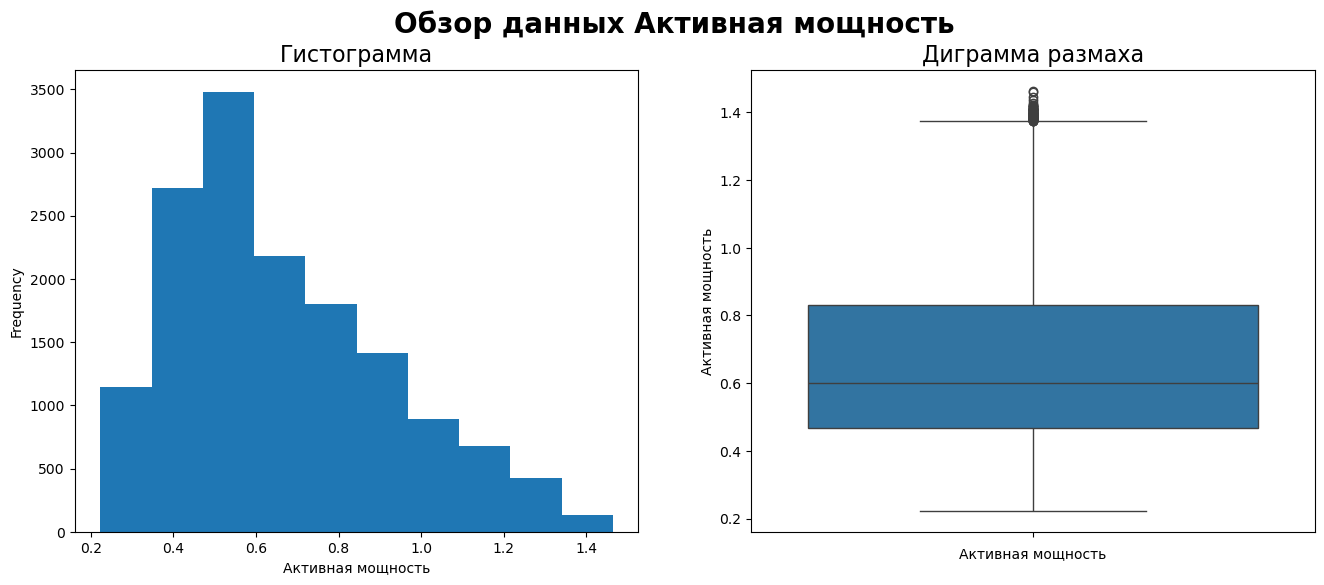

In [ ]:
# Посмотрим на графики признака "Активная мощность"
hix_box_plot(data_arc, 'Активная мощность')

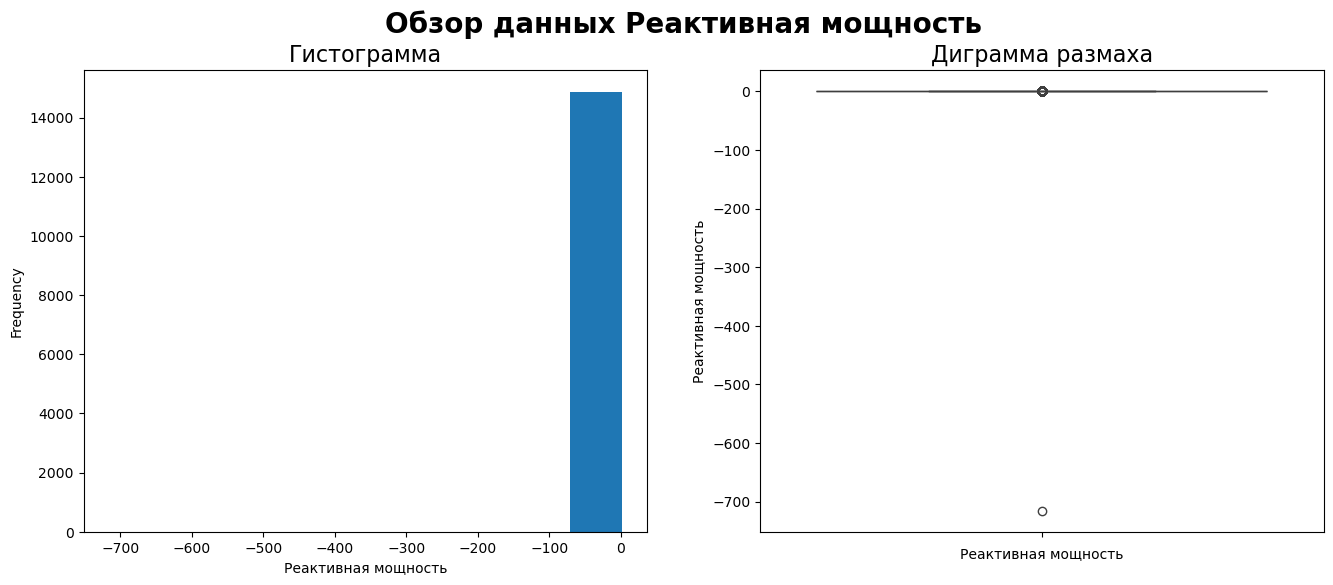

In [ ]:
# Посмотрим на графики признака "Реактивная мощность"
hix_box_plot(data_arc, 'Реактивная мощность')

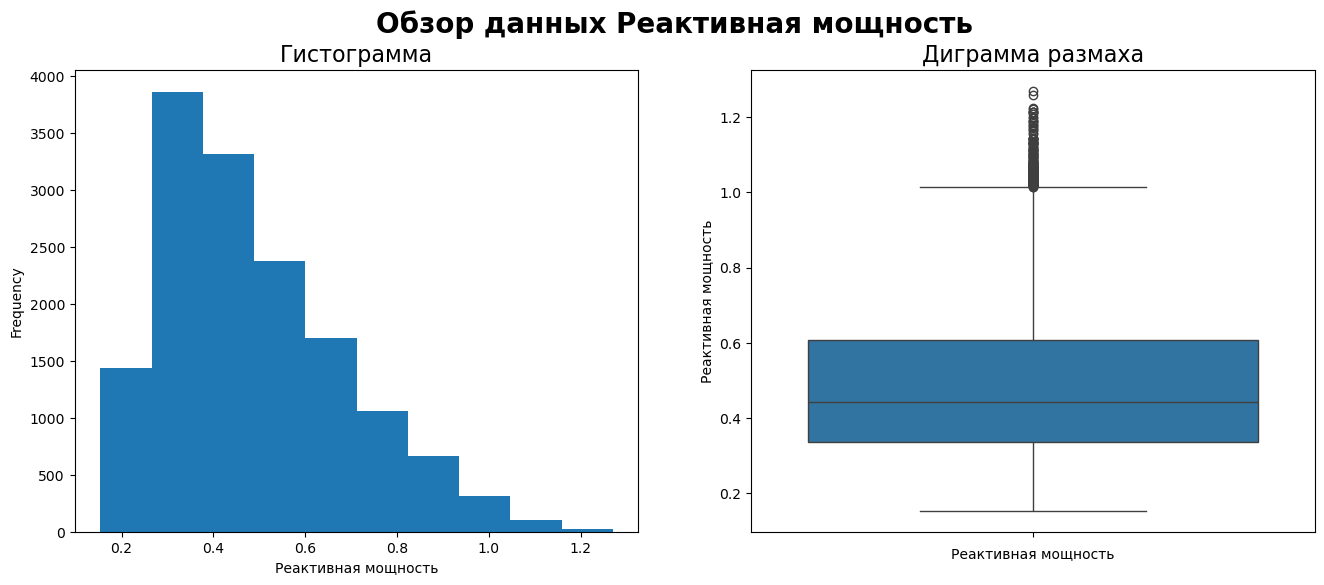

In [ ]:
# Посмотрим на графики признака "Реактивная мощность" без выброса
hix_box_plot(data_arc[data_arc['Реактивная мощность'] > 0], 'Реактивная мощность')

#### Выводы по датафрейму data_arc

* Датафрейм содержит 14876 записей, состоящих из 5 признаков
* Датафрейм не содержит пропуски и дубликаты
* Признак "Активная мощность" не имеет выбросов
* Признак "Реактивная мощность" имеет выбросы, изучим и обработаем их позже
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### data_bulk

In [ ]:
# Посмотрим на информацию о датафрейме data_bulk
df_review(data_bulk)

Краткое содержание датафрейма


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
Размер датафрейма: (3129, 16)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


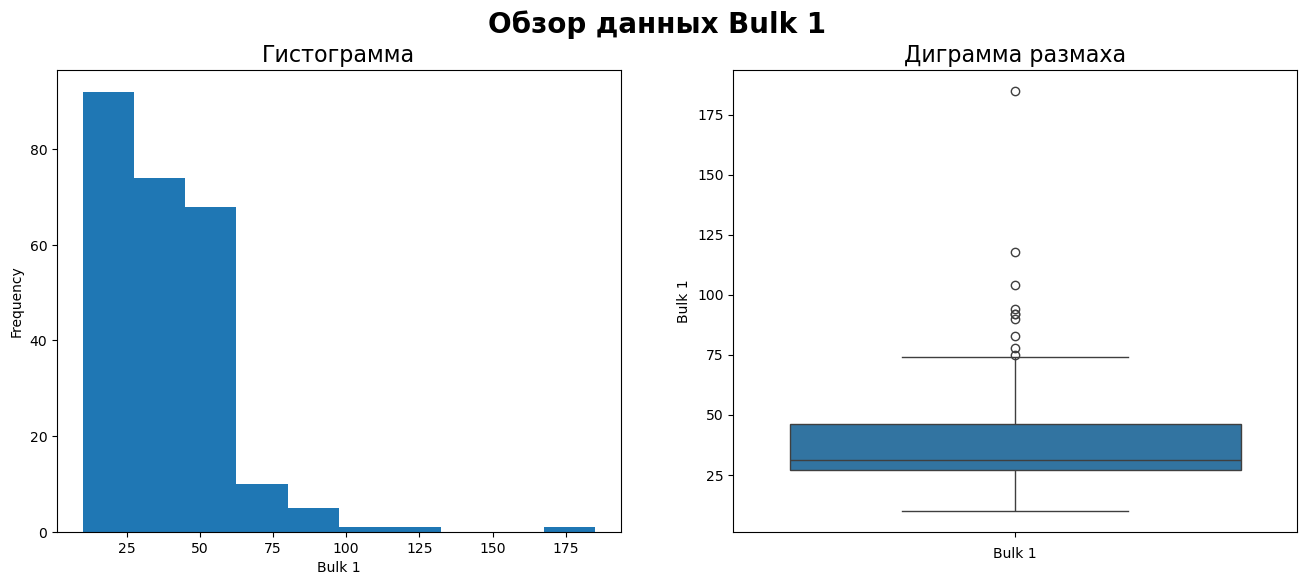

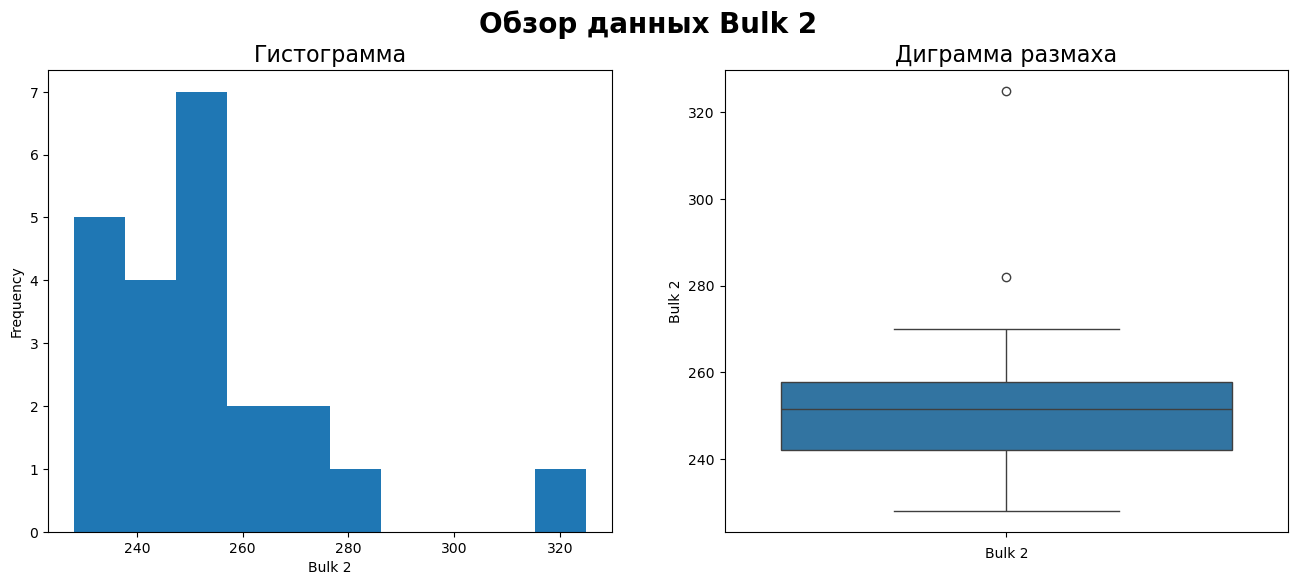

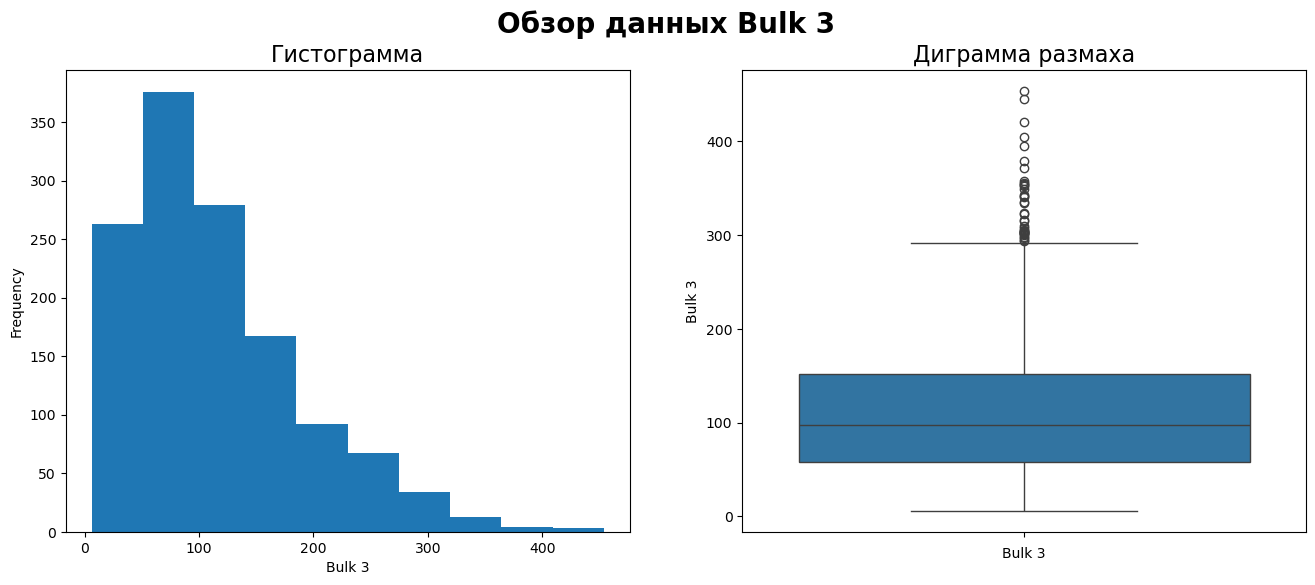

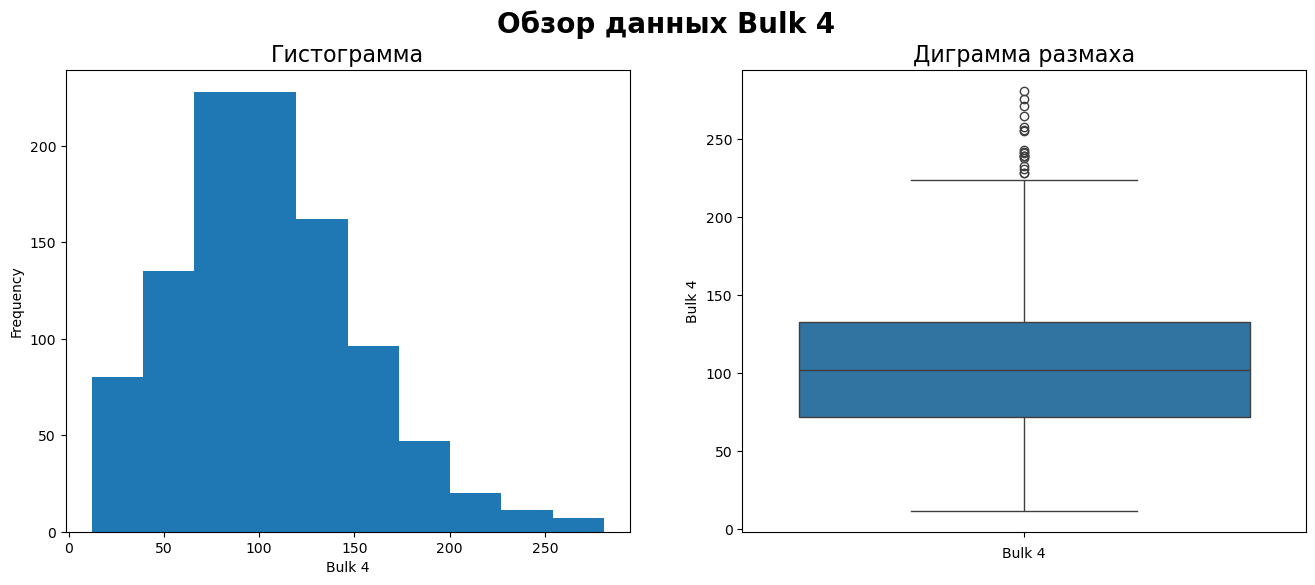

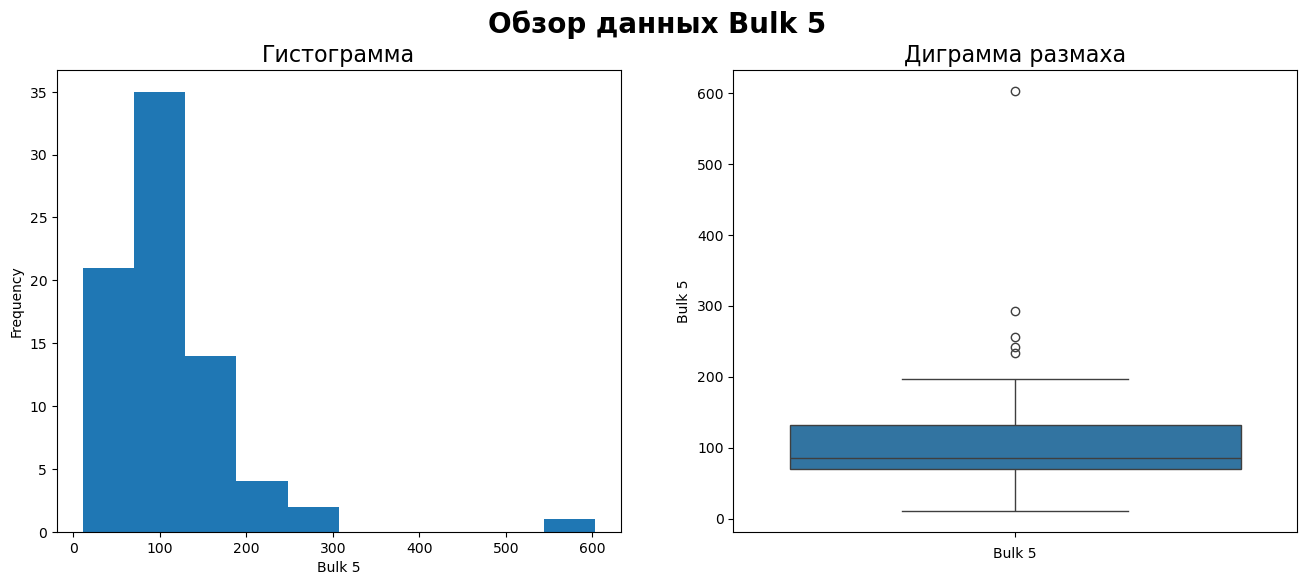

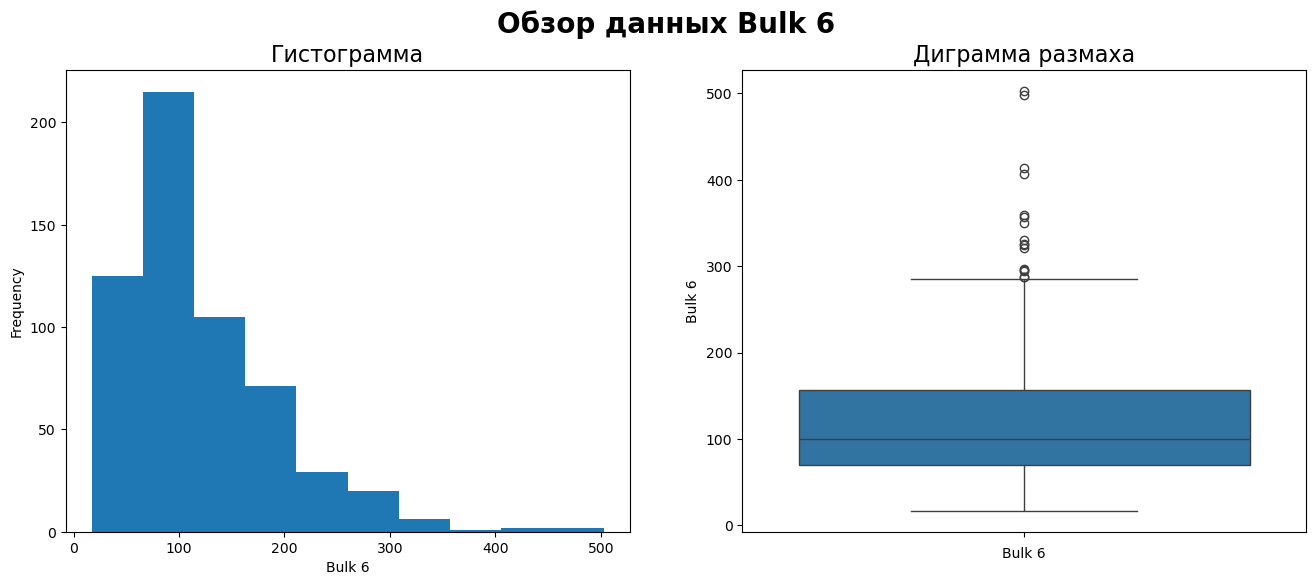

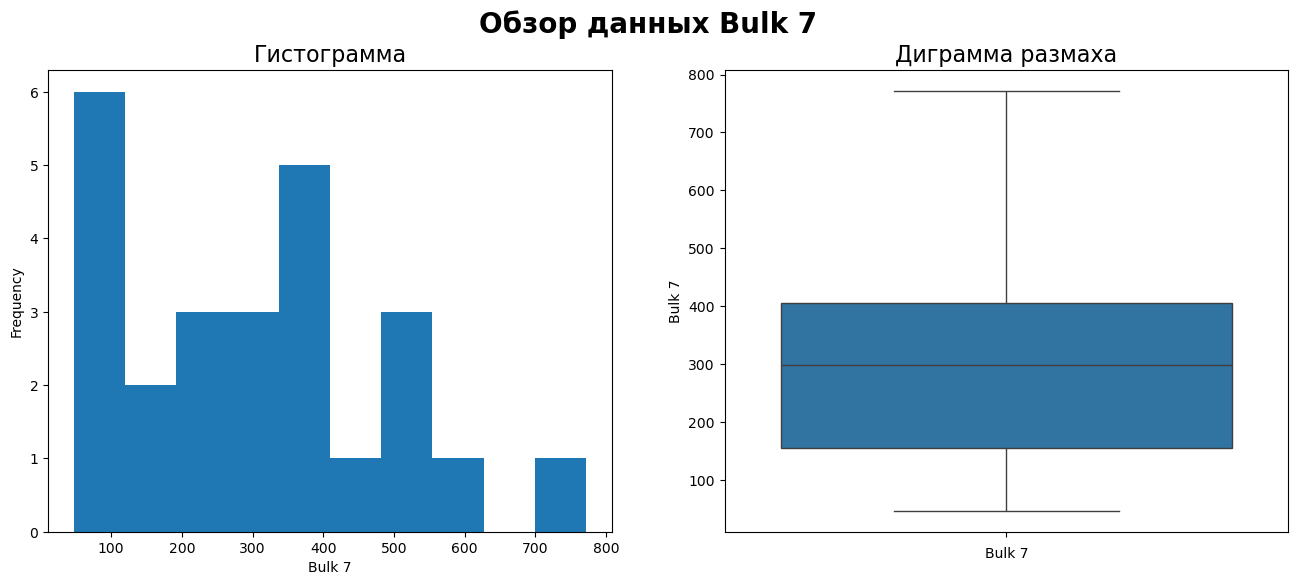

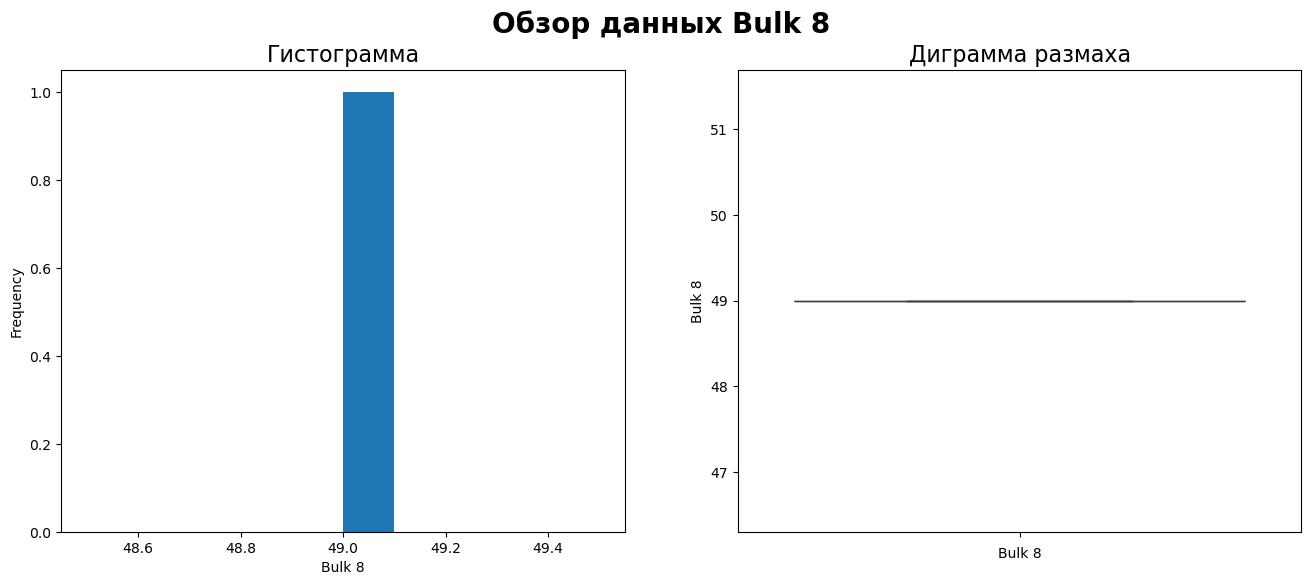

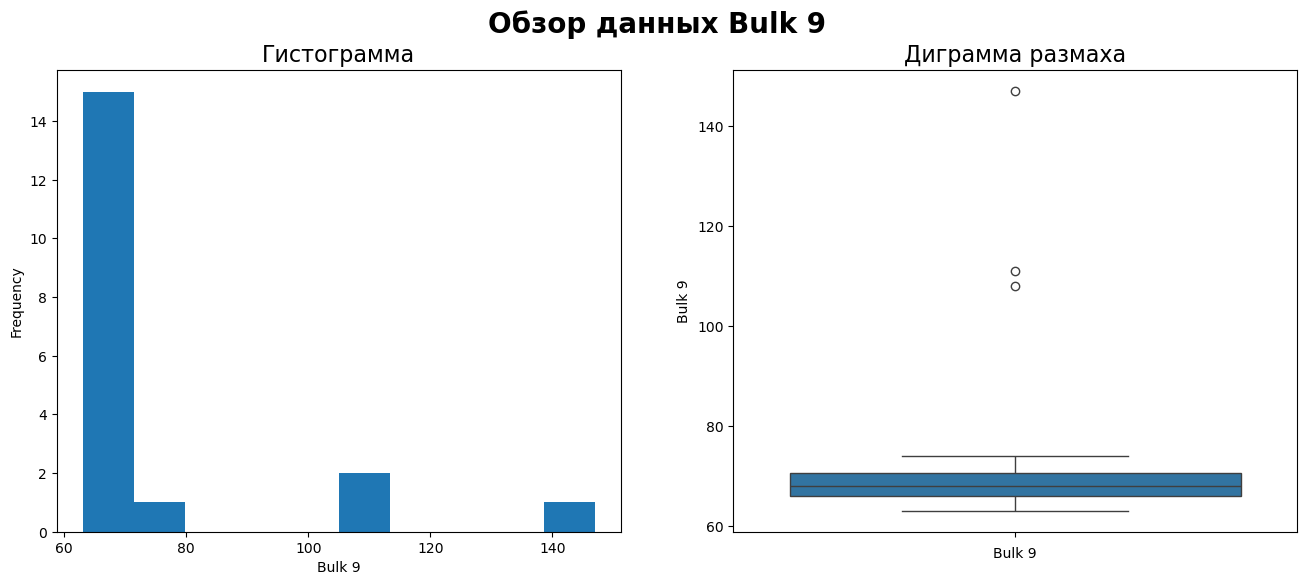

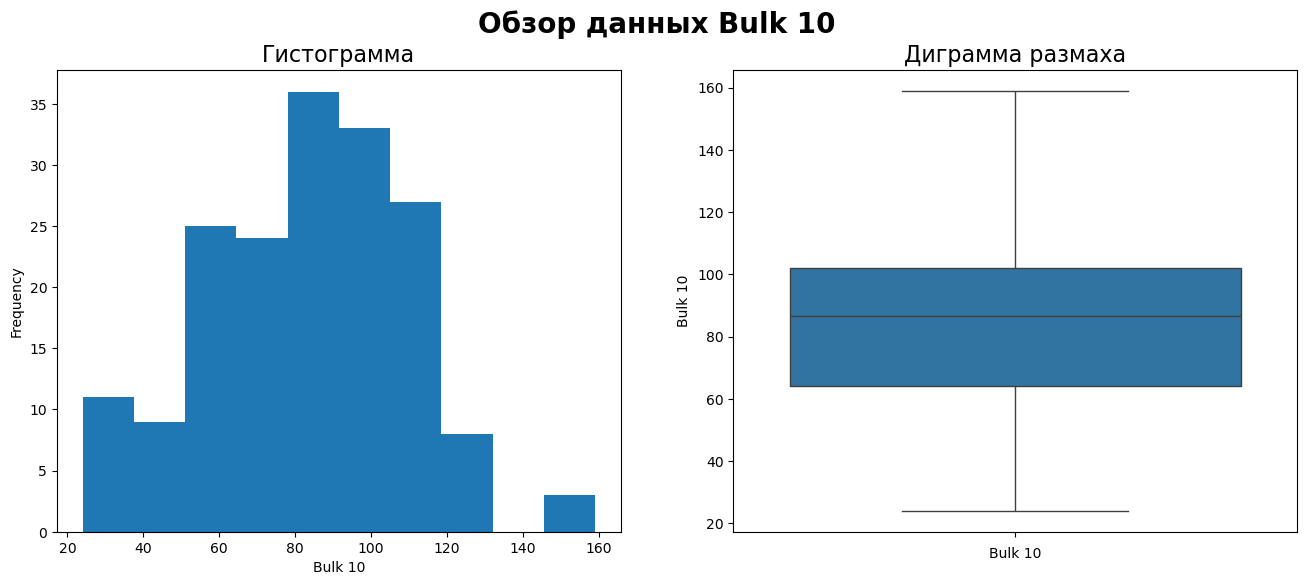

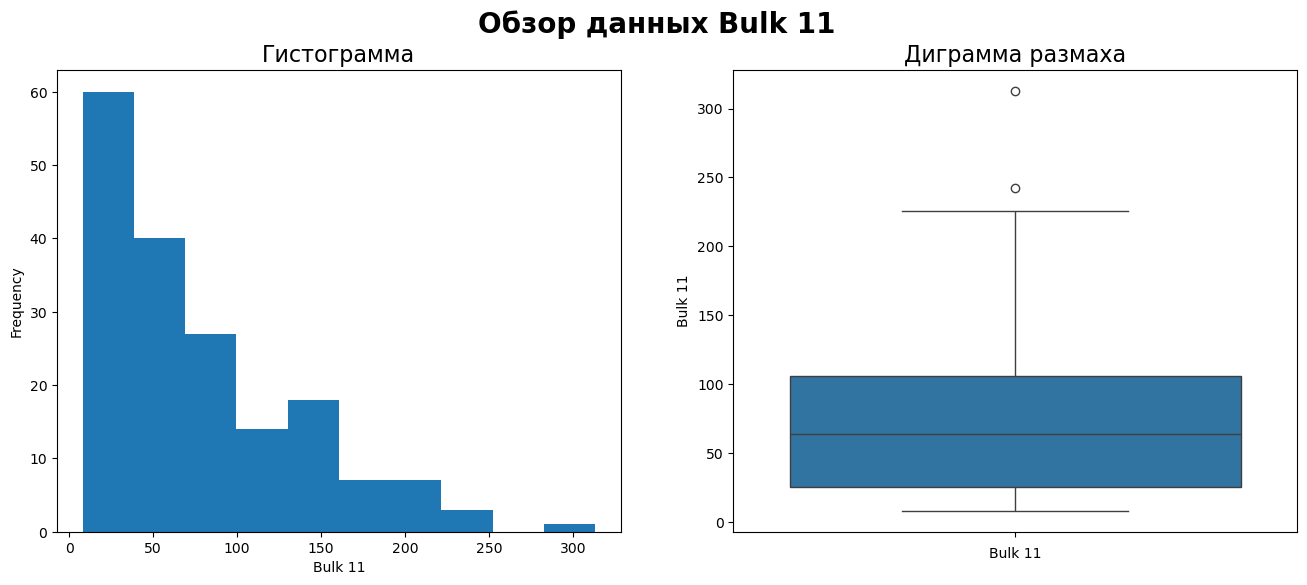

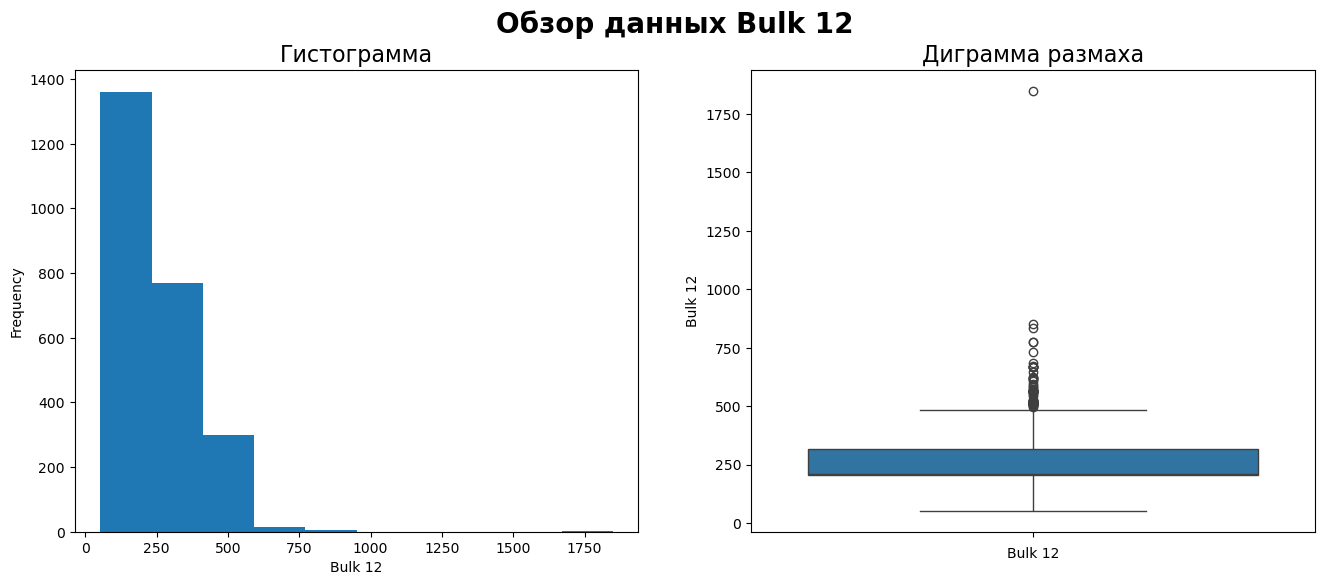

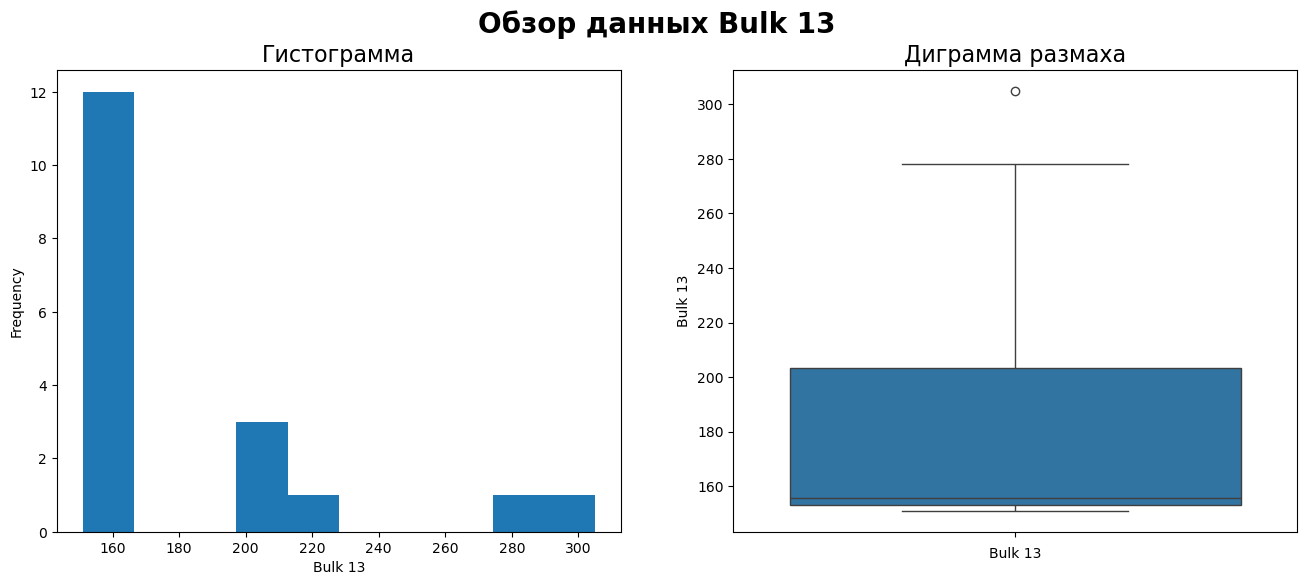

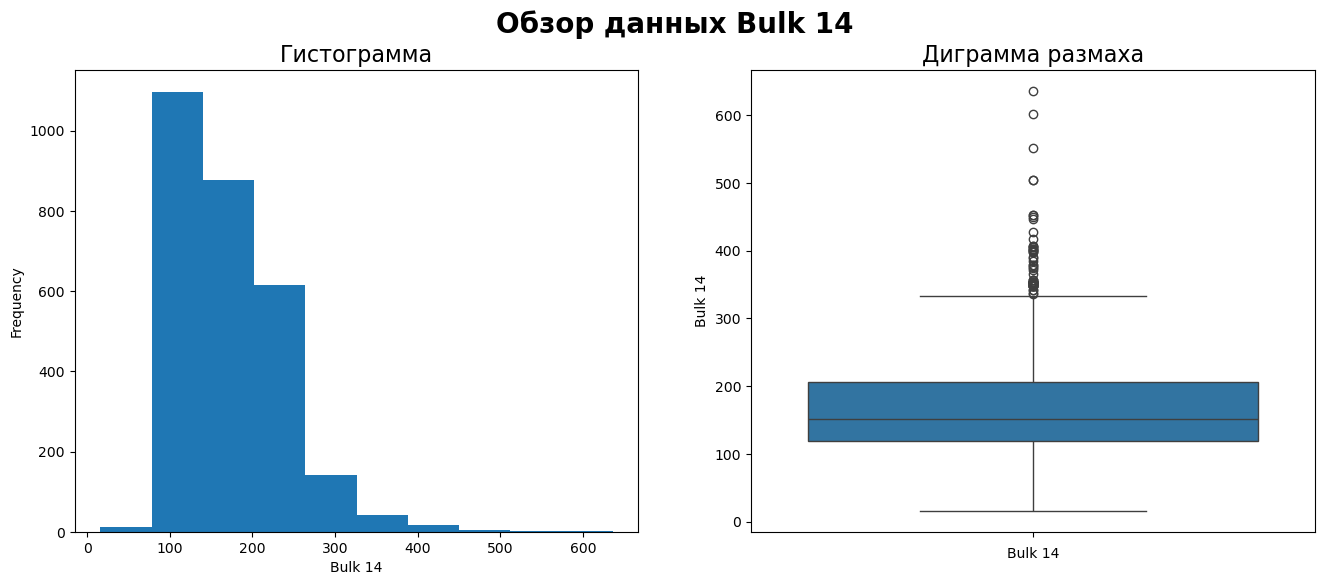

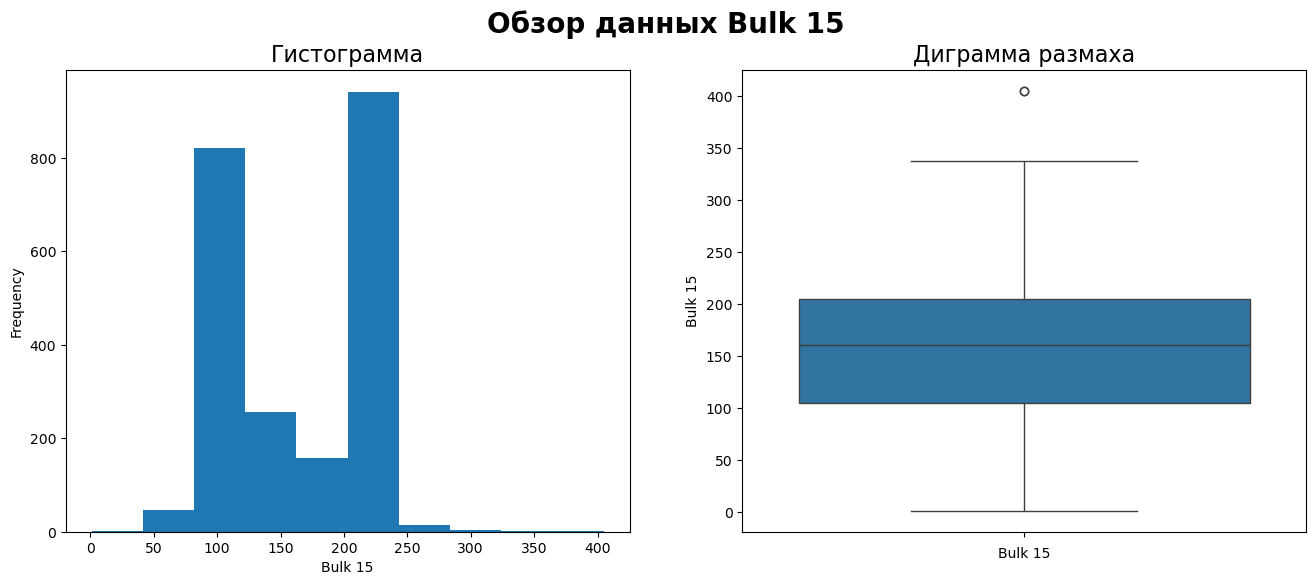

In [ ]:
# Посмотрим на графики признаков "Bulk"

# Для удобства перечислим признаки через цикл
for column in data_bulk.columns:
    if column[0] == 'B':
        hix_box_plot(data_bulk, column)


#### Выводы по датафрейму data_bulk

* Датафрейм содержит 3129 записей, состоящих из 16 признаков
* Датафрейм содержит множественные пропуски - пропуски значат, что сыпучие материалы не добавлялись
* Практически все признаки имеют выбросы
* Признак "Bulk_8" указан всего в одной записи
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### data_bulk_time

In [ ]:
# Посмотрим на информацию о датафрейме data_bulk_time
df_review(data_bulk_time)

Краткое содержание датафрейма


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
Размер датафрейма: (3129, 16)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


#### Выводы по датафрейму data_bulk_time

* Датафрейм содержит 3129 записей, состоящих из 16 признаков
* Датафрейм содержит множественные пропуски - пропуски значат, что сыпучие материалы не добавлялись
* Практически все признаки имеют выбросы
* Признак "Bulk_8" указан всего в одной записи
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### data_gas

In [ ]:
# Посмотрим на информацию о датафрейме data_gas
df_review(data_gas)

Краткое содержание датафрейма


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Размер датафрейма: (3239, 2)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key      0
Газ 1    0
dtype: int64


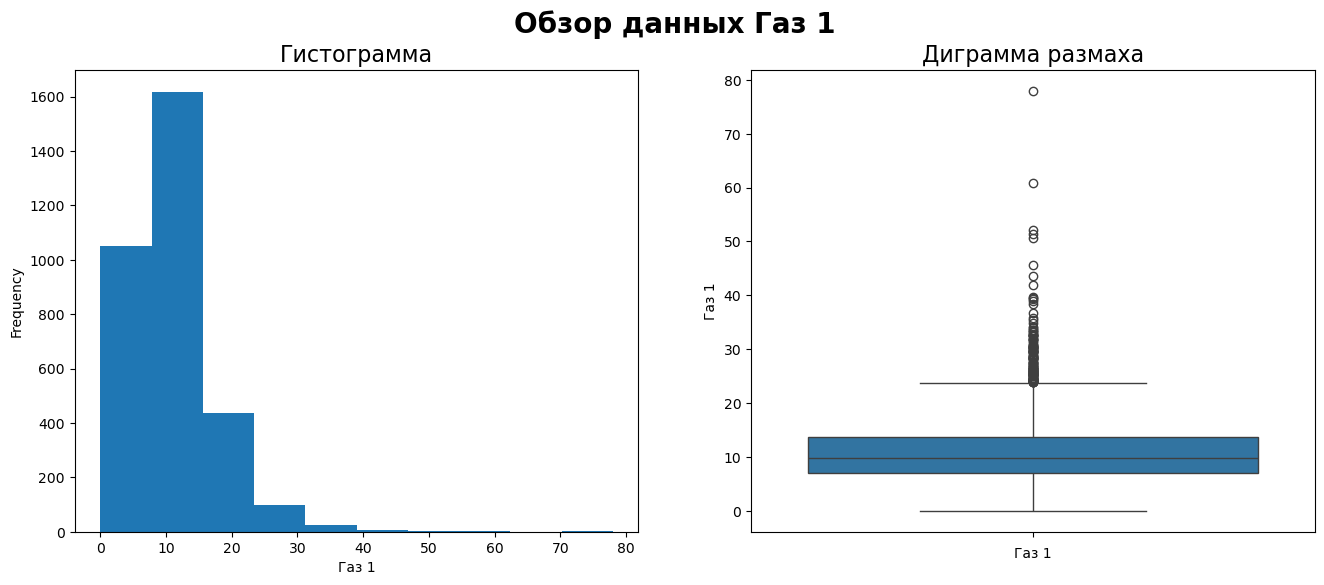

In [ ]:
# Посмотрим на графики признака "Газ 1"
hix_box_plot(data_gas, 'Газ 1')

#### Выводы по датафрейму data_gas

* Датафрейм содержит 3239 записей, состоящих из 2 признаков
* Датафрейм не содержит пропуски и дубликаты
* Признак "Газ 1" имеет выбросы, изучим и обработаем их позже
* Возможно данный датафрейм можно использоваться для объединения общего датафрейма без изменений, решим это после исследовательского анализа и предобработки

### data_temp

In [ ]:
# Посмотрим на информацию о датафрейме data_temp
df_review(data_temp)

Краткое содержание датафрейма


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
Размер датафрейма: (18092, 3)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key                0
Время замера       0
Температура     3427
dtype: int64


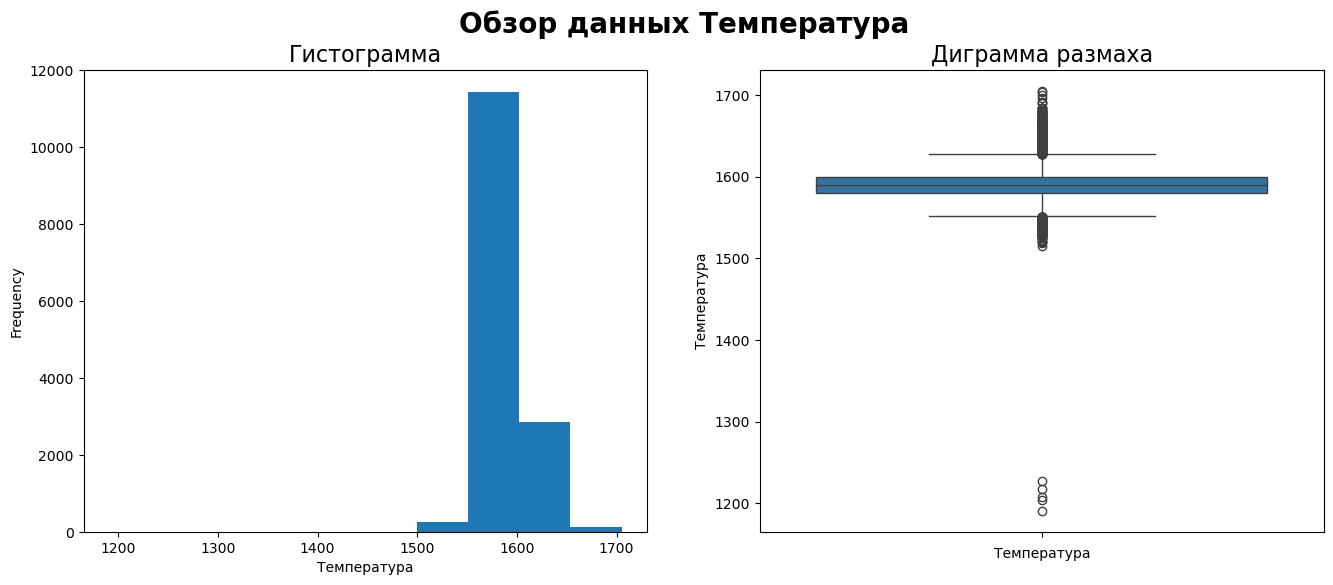

In [ ]:
# Посмотрим на графики признака "Температура"
hix_box_plot(data_temp, 'Температура')

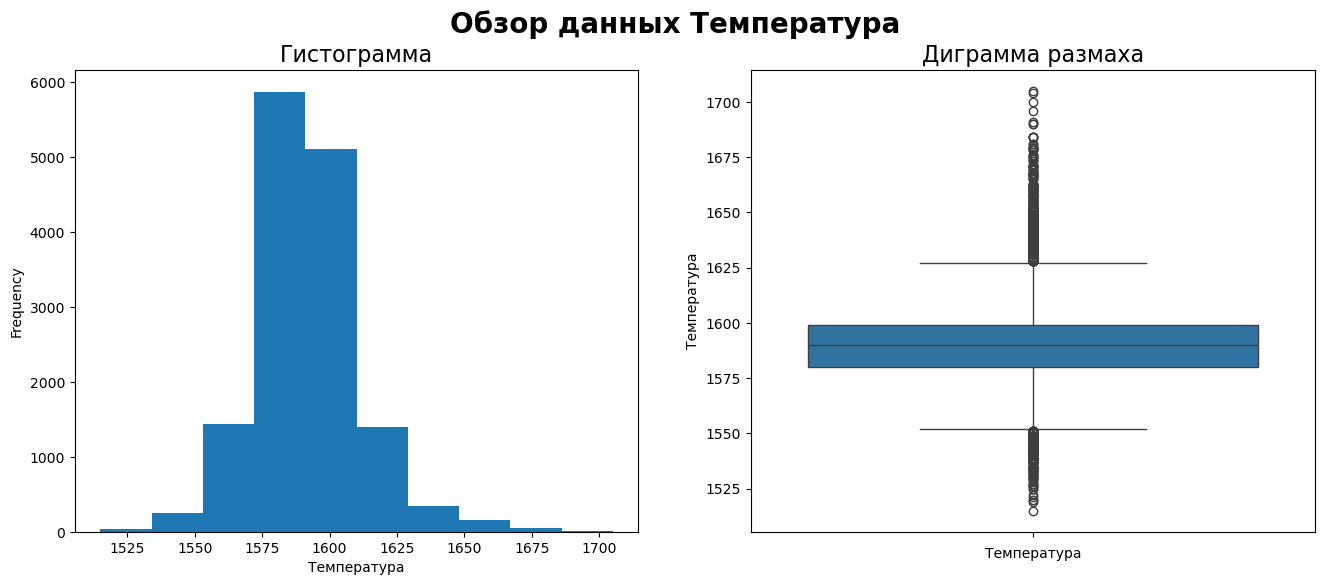

In [ ]:
# Посмотрим на графики признака "Температура" без выброса
hix_box_plot(data_temp[data_temp['Температура'] > 1400], 'Температура')

#### Выводы по датафрейму data_temp

* Датафрейм содержит 18092 записей, состоящих из 3 признаков
* Датафрейм содержит пропуски
* Признак "Температура" имеет выбросы, изучим и обработаем их позже
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### data_wire

In [ ]:
# Посмотрим на информацию о датафрейме data_wire
df_review(data_wire)

Краткое содержание датафрейма


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Размер датафрейма: (3081, 10)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


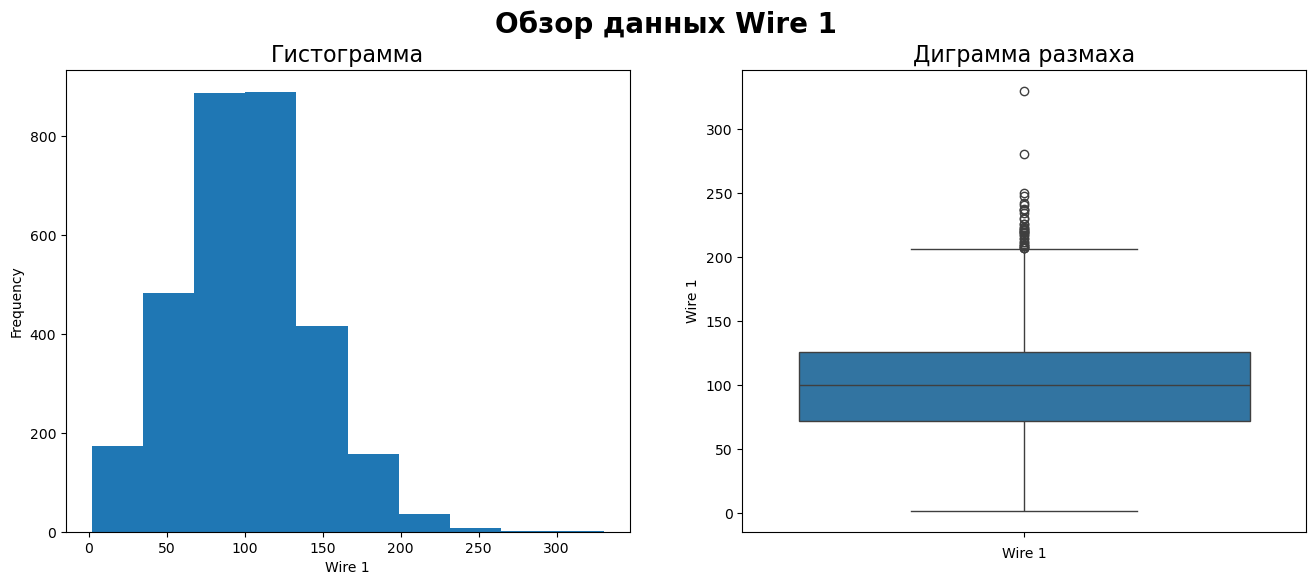

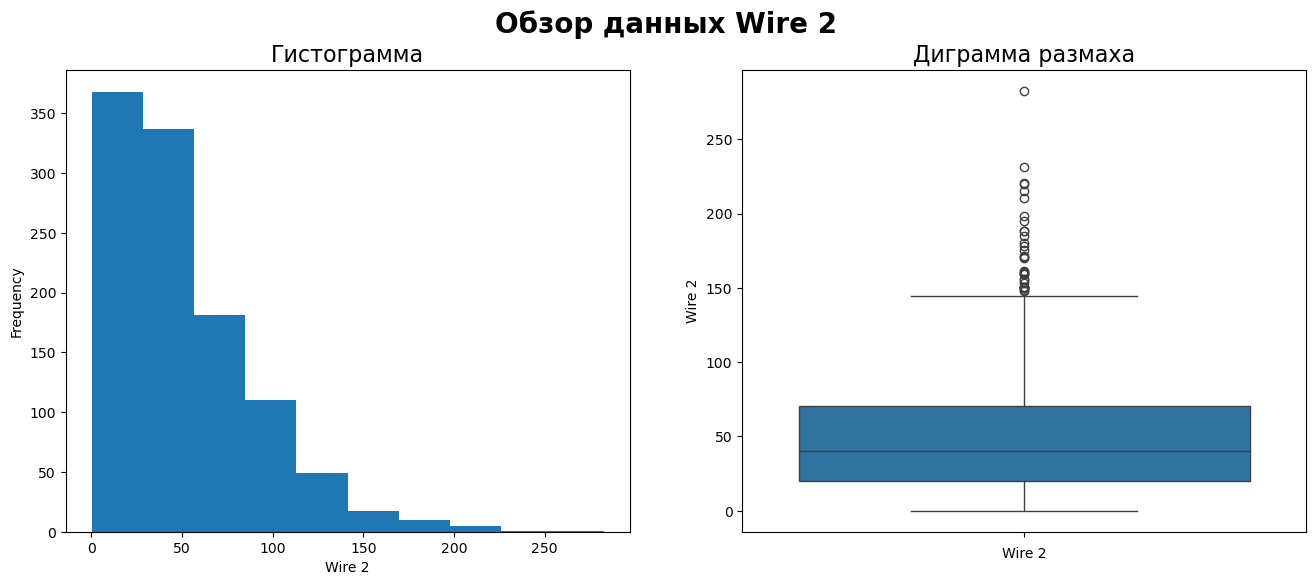

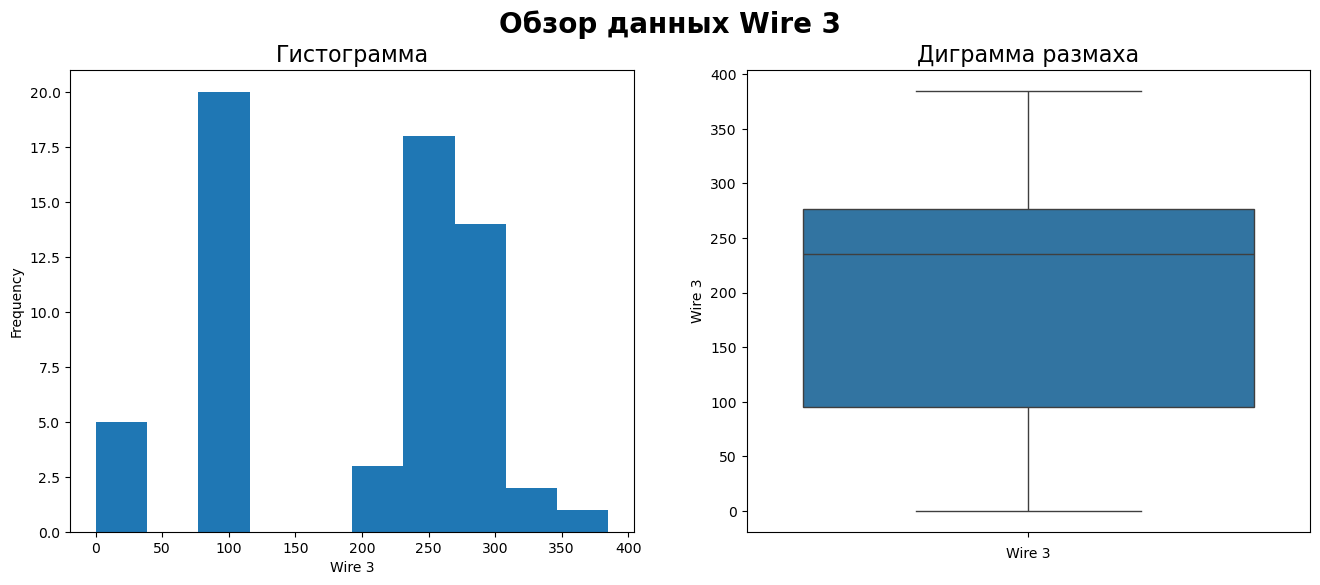

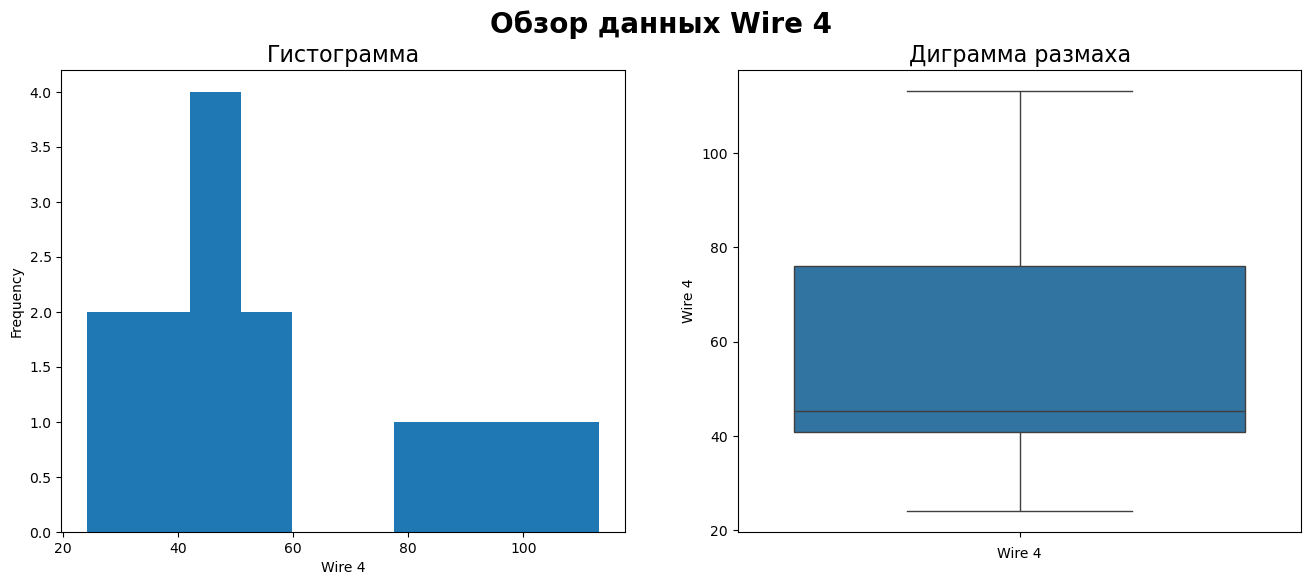

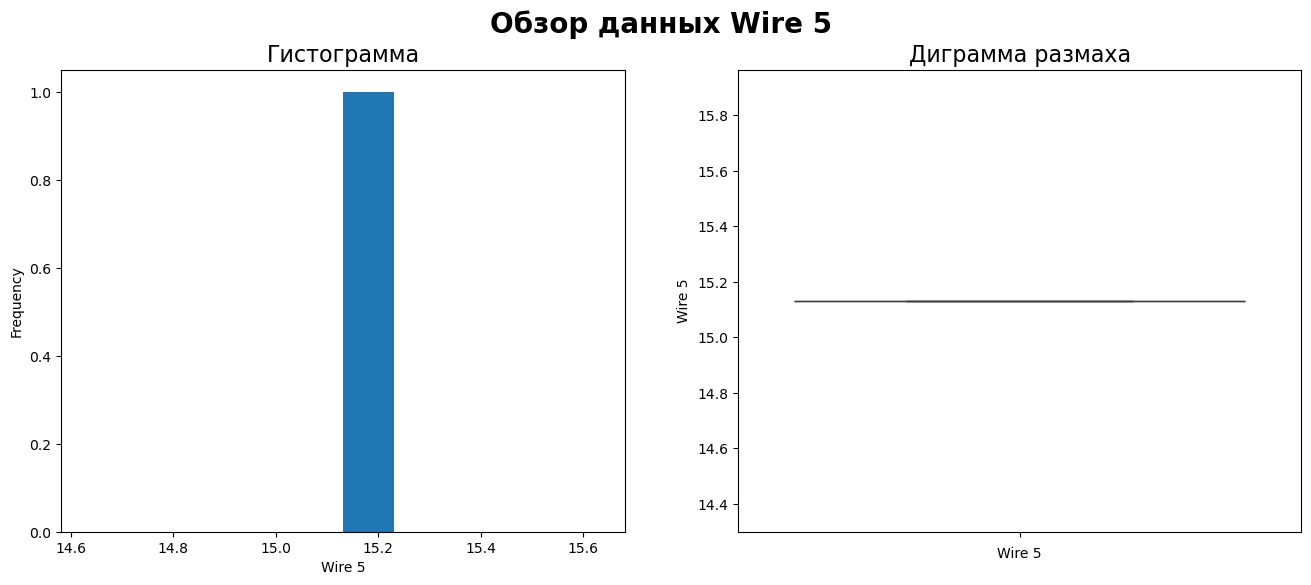

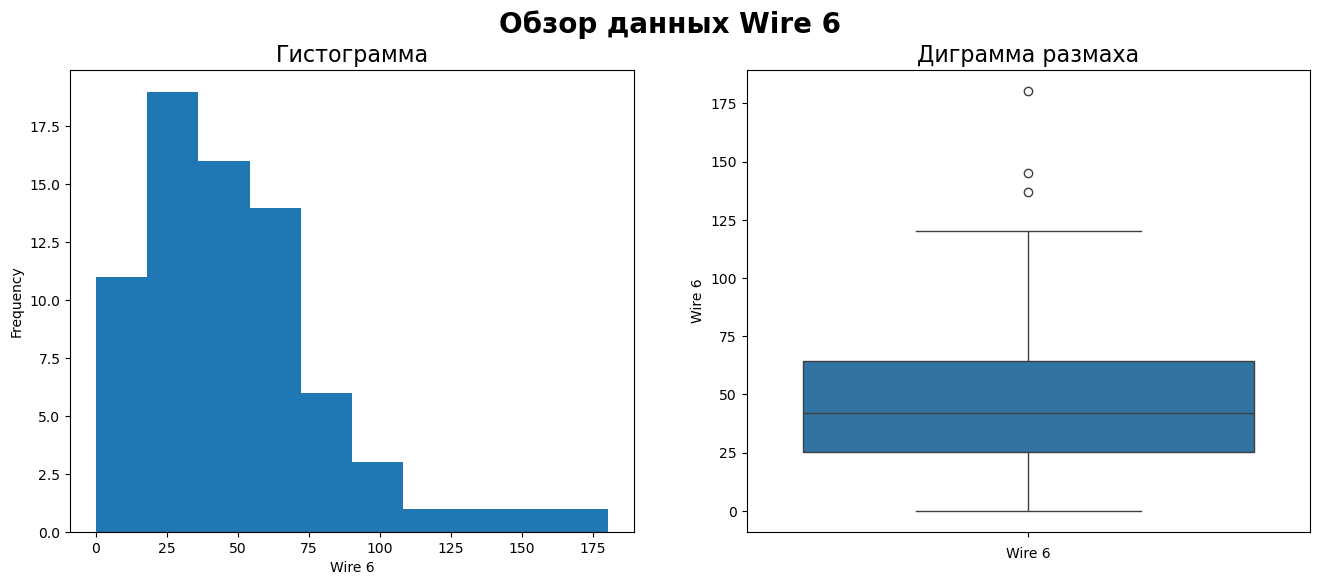

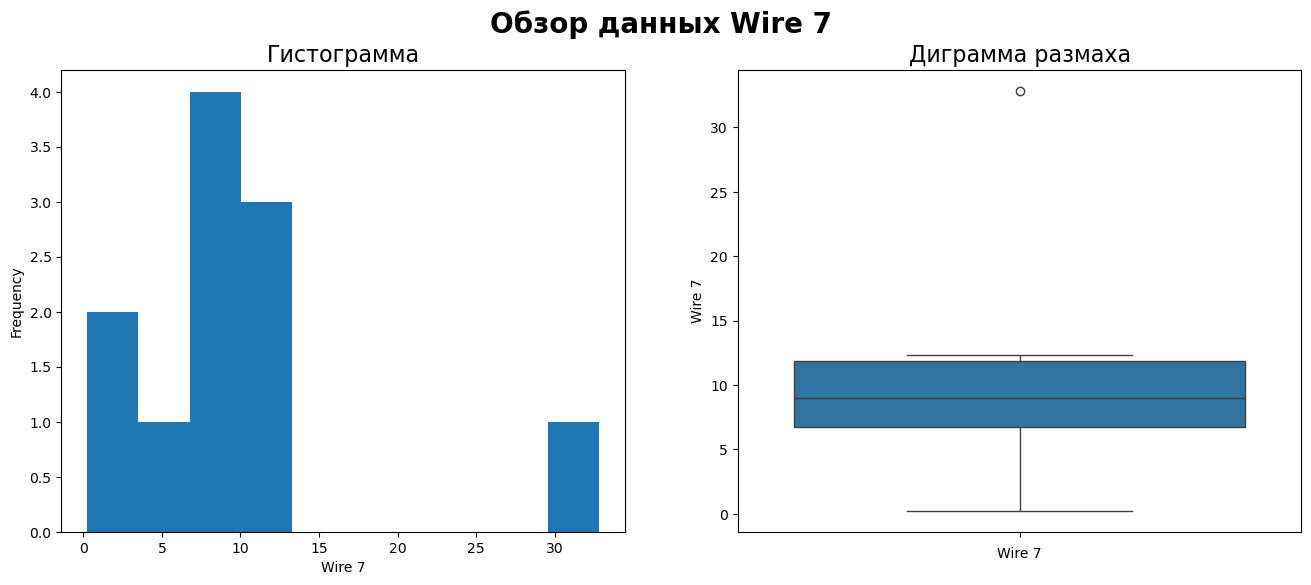

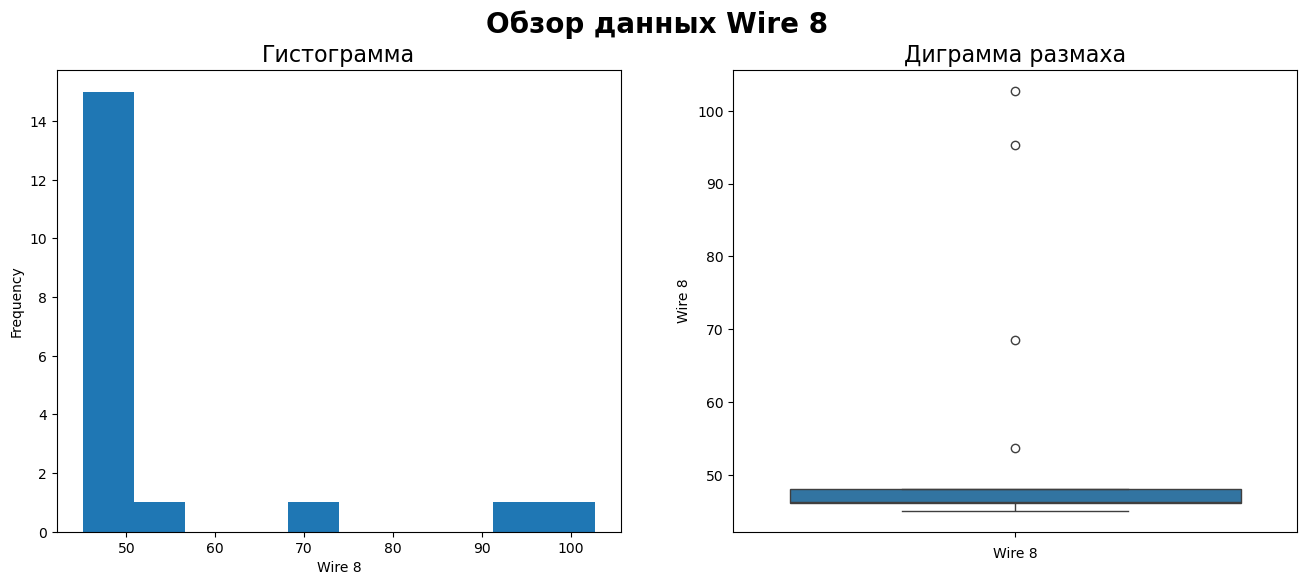

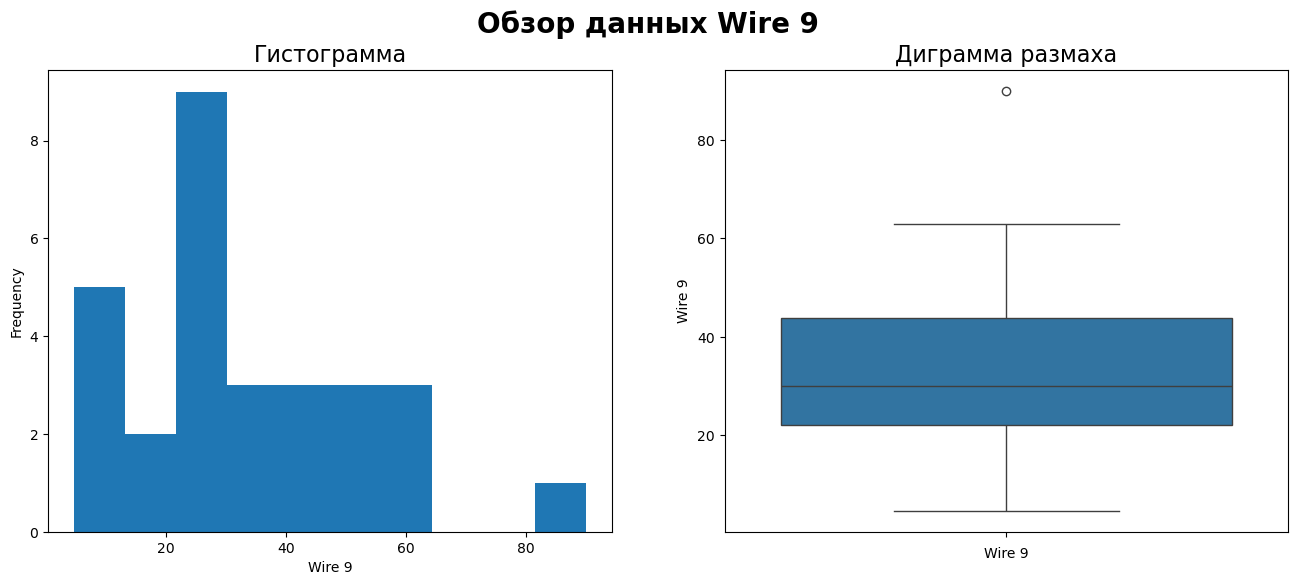

In [ ]:
# Посмотрим на графики признаков "Wire"

# Для удобства перечислим признаки через цикл
for column in data_wire.columns:
    if column[0] == 'W':
        hix_box_plot(data_wire, column)


#### Выводы по датафрейму data_wire

* Датафрейм содержит 3129 записей, состоящих из 16 признаков
* Датафрейм содержит множественные пропуски - пропуски значат, что проволочные материалы не подавались
* Практически все признаки имеют выбросы
* Признак "Bulk_5" указан всего в одной записи
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### data_wire_time

In [ ]:
# Посмотрим на информацию о датафрейме data_wire_time
df_review(data_wire_time)

Краткое содержание датафрейма


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Размер датафрейма: (3081, 10)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


#### Выводы по датафрейму data_wire_time

* Датафрейм содержит 3129 записей, состоящих из 16 признаков
* Датафрейм содержит множественные пропуски - пропуски значат, что проволочные материалы не подавались
* Практически все признаки имеют выбросы
* Признак "Bulk_5" указан всего в одной записи
* По данному датафрейму сгруппируем записи по ключу формируя новые признаки на основе имеющихся

### Выводы по исследовательскому анализу данных

* Столбцы в датафреймах имеют пропуски, которые необходимо обработать.
* Некоторые данные имеют неподходящий тип данных.
* Скорее всего все датафреймы необходимо обработать перед объединением общего датафрейма.
* По совету заказчика необходимо удалить выбросы в признаке *"Реактивная мощность"* датафрейма **data_arc** и признаке *"Температура"* датафрейма **data_temp**.
* Выбросы в остальных признаках стоит проверить.

## Предобработка данных

### data_arc

В первую очередь удалим аномальные выбросы в признаке "Реактивная мощность". Судя по исследовательскому анализу такие выбросы являются отрицательными значениями. Проверим все записи с такими значениями реактивной мощности.

In [ ]:
# Отобразим записи с отрицательными значениями реактивной мощности
data_arc.loc[data_arc["Реактивная мощность"] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Отрицательное значение реактивной мощности имеет всего одна запись, удалим записи с данным ключом.

In [ ]:
# Удаляем из датафрейма все записи с ключом 2116
data_arc = data_arc.loc[data_arc['key'] != 2116]

Исходя из найденой на просторах интернета формулы полной мощности создадим новый признак с полной мощностью нагрева дугой.

In [ ]:
# Считаем общую мощность для каждой записи
data_arc['Полная мощность'] = np.sqrt((data_arc['Активная мощность'])**2 + (data_arc['Реактивная мощность'])**2)

Проведём анализ нового признака.

In [ ]:
# Посмотрим на 10 случайных записей датафрейма с новым признаком
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
4837,1044,2019-06-12 14:47:58,2019-06-12 14:52:29,0.556204,0.474266,0.730952
8154,1770,2019-07-08 07:09:47,2019-07-08 07:14:55,0.520616,0.331082,0.616974
13172,2862,2019-08-24 04:00:10,2019-08-24 04:02:56,0.959415,0.633587,1.149743
3717,806,2019-06-03 22:54:38,2019-06-03 23:00:36,0.646506,0.561927,0.856582
7836,1696,2019-07-05 18:37:17,2019-07-05 18:40:14,1.184585,1.021020,1.563881
1272,278,2019-05-14 09:09:05,2019-05-14 09:12:20,0.507813,0.373610,0.630443
12498,2717,2019-08-18 12:56:28,2019-08-18 12:57:21,0.324311,0.267904,0.420654
10270,2230,2019-07-31 20:50:12,2019-07-31 20:51:51,1.322425,1.132039,1.740781
14586,3173,2019-09-04 07:20:35,2019-09-04 07:21:03,0.291379,0.208337,0.358198
11330,2470,2019-08-09 11:23:33,2019-08-09 11:27:18,0.562344,0.407164,0.694272


In [ ]:
# Охарактеризуем данный признак
data_arc['Полная мощность'].describe()

count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: Полная мощность, dtype: float64

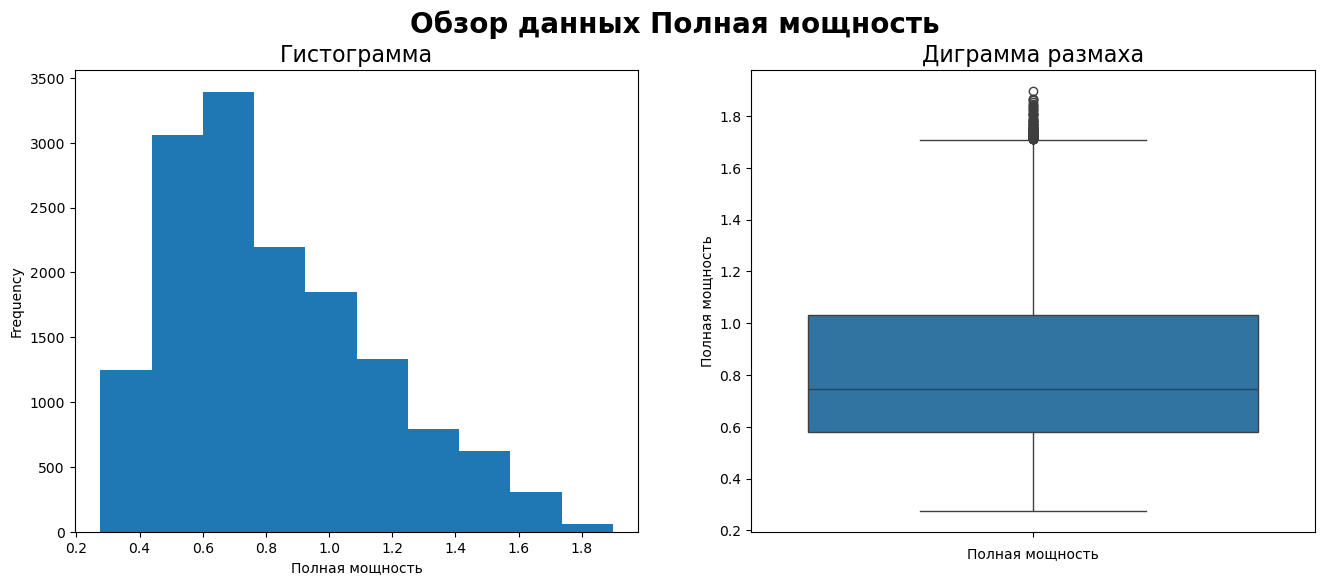

In [ ]:
# Посмотрим на графики признака
hix_box_plot(data_arc, 'Полная мощность')

Изменим тип данных признаков о времени нагрева.

In [ ]:
# Приведём временные типы данных в единый формат
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y-%m-%d %H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

Добавим дополнительный признак о времени нагрева в секундах для каждой записи.

In [ ]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой']).dt.seconds

In [ ]:
# Посмотрим на 10 случайных записей датафрейма с новым признаком
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
10994,2391,2019-08-06 17:45:50,2019-08-06 17:47:16,0.814714,0.630994,1.030491,86
9596,2080,2019-07-26 06:59:38,2019-07-26 07:01:39,0.502452,0.364122,0.620518,121
8513,1852,2019-07-11 03:20:46,2019-07-11 03:22:57,0.711257,0.493175,0.865510,131
10536,2289,2019-08-02 21:54:10,2019-08-02 22:01:09,1.255980,0.866134,1.525672,419
10155,2204,2019-07-30 22:38:01,2019-07-30 22:41:43,1.316833,0.910673,1.601054,222
98,22,2019-05-04 04:27:33,2019-05-04 04:29:36,0.416693,0.282269,0.503298,123
12406,2697,2019-08-17 19:01:26,2019-08-17 19:04:11,0.832369,0.561918,1.004286,165
1247,274,2019-05-14 04:38:53,2019-05-14 04:44:01,0.665259,0.437736,0.796356,308
14564,3169,2019-09-04 03:46:39,2019-09-04 03:49:48,0.491133,0.373384,0.616950,189
11461,2502,2019-08-10 15:53:26,2019-08-10 15:55:38,1.091857,0.913493,1.423594,132


In [ ]:
# Охарактеризуем данный признак
data_arc['Время нагрева'].describe()

count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Время нагрева, dtype: float64

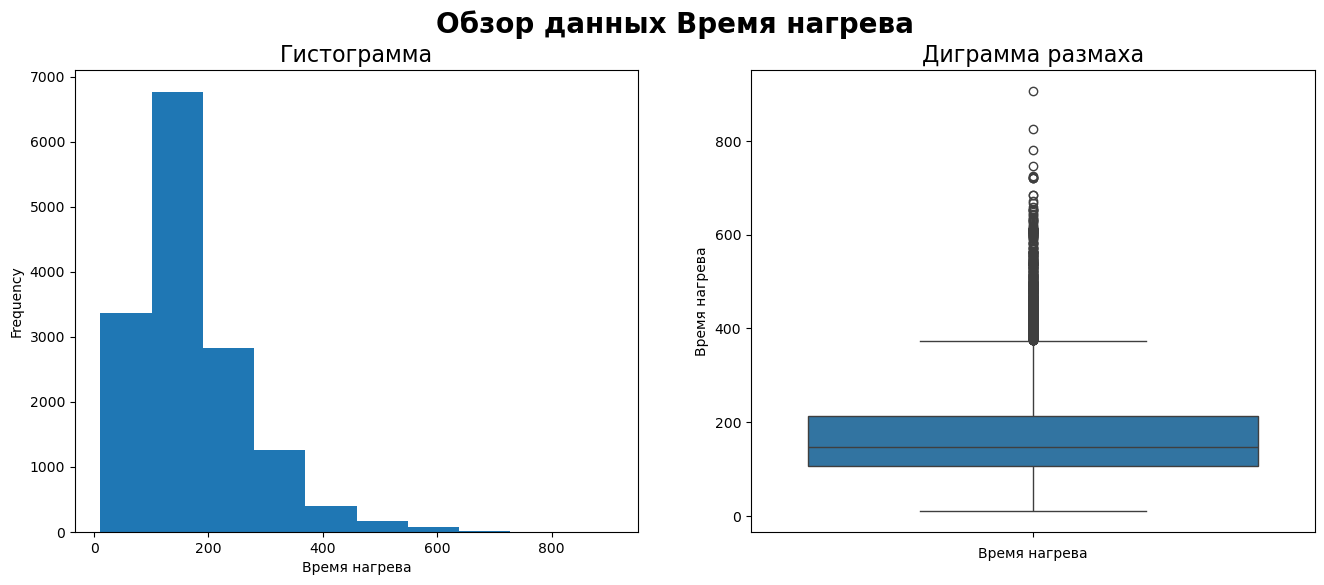

In [ ]:
# Посмотрим на графики признака
hix_box_plot(data_arc, 'Время нагрева')

Выбросы довольно сильно отличаются от средних значений, но в виду особенностей производства даже самое большое значение вполне реально.

Сгруппируем необходимые данные по ключу.

In [ ]:
# Группируем данные по ключу
data = data_arc.groupby("key").agg({"Полная мощность":"sum",
                                    "Время нагрева":"sum"}).reset_index()

In [ ]:
# Посмотрим на 10 случайных записей получившегося датафрейма
data.sample(10)

,key,Полная мощность,Время нагрева
719,732,1.161089,170
976,990,3.513564,809
554,564,3.548860,660
2750,2777,1.670284,357
546,556,0.507460,125
2141,2161,4.058464,624
799,813,7.564909,2247
977,991,4.305503,632
2896,2923,2.409186,483
905,919,4.706468,959


In [ ]:
# Посмотрим информацию о датафрейме
df_review(data)

Краткое содержание датафрейма


,key,Полная мощность,Время нагрева
0,1,3.718736,1098
1,2,2.588349,811
2,3,5.019223,655
3,4,3.400038,741
4,5,2.816980,869


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3213 non-null   int64  
 1   Полная мощность  3213 non-null   float64
 2   Время нагрева    3213 non-null   int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 62.9 KB
Размер датафрейма: (3213, 3)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3213.0,1622.907874,934.844882,1.000000,817.000000,1623.000000,2432.000000,3241.000000
Полная мощность,3213.0,3.811201,1.502848,0.331897,2.775577,3.694535,4.697427,15.288271
Время нагрева,3213.0,794.691566,332.439136,57.000000,571.000000,770.000000,983.000000,4189.000000


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key                0
Полная мощность    0
Время нагрева      0
dtype: int64


### data_temp

В датафрейме имеются пропуски в значениях температуры, удалим все записи по key, где есть хотя бы один пропуск, т.к. они связаны скорее всего с неудавшимся замером и их нечем заполнить.

In [ ]:
# Находим ключи, у которых есть хотя бы один пропуск в столбце "Температура"
keys_with_missing_temp = data_temp[data_temp["Температура"].isna()]["key"].unique()

# Удаляем все строки с этими ключами
data_temp = data_temp[~data_temp["key"].isin(keys_with_missing_temp)]

Так же по совету заказчика мы знаем, что выбросы в виде температуры ниже 1400 являются аномальными выбросами. Удалим все записи по key, где хотя бы одно значение температуры ниже 1400.

In [ ]:
# Находим ключи, у которых есть хотя бы одно значение в столбце "Температура" ниже 1400
keys_with_missing_temp = data_temp[data_temp["Температура"] < 1400]["key"].unique()

# Удаляем все строки с этими ключами
data_temp = data_temp[~data_temp["key"].isin(keys_with_missing_temp)]

In [ ]:
# Посмотрим на информацию о датафрейме
df_review(data_temp)

Краткое содержание датафрейма


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13905 non-null  int64  
 1   Время замера  13905 non-null  object 
 2   Температура   13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB
Размер датафрейма: (13905, 3)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,13905.0,1243.325710,719.395520,1.0,623.0,1246.0,1870.0,2499.0
Температура,13905.0,1590.924847,18.750314,1519.0,1580.0,1590.0,1599.0,1705.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key             0
Время замера    0
Температура     0
dtype: int64


Сгруппируем все данные датафрейма по ключу.

In [ ]:
# Создадим датафрейм с начальной температурой и временем первого замера температуры
data_temp_first = data_temp.groupby("key").agg({"Время замера":"first"}).reset_index()
data_temp_first = pd.merge(data_temp_first, data_temp, how="left", on=["key", 'Время замера'])
data_temp_first = data_temp_first.rename(columns={"Температура": "Начальная температура",
                                                  "Время замера": "Первый замер температуры"})

# Аналогично создадим датафрейм с финальной температурой и временем последнего замера
data_temp_last = data_temp.groupby("key").agg({"Время замера":"last"}).reset_index()
data_temp_last = pd.merge(data_temp_last, data_temp, how="left", on=["key", 'Время замера'])
data_temp_last = data_temp_last.rename(columns={"Температура": "Финальная температура",
                                                "Время замера": "Последний замер температуры"})

# Объединяем оба датафрейма в один общий
data_temp_full = pd.merge(data_temp_first, data_temp_last, how="inner", on=["key"])

In [ ]:
# Посмотрим на получившийся датафрейм
df_review(data_temp_full)

Краткое содержание датафрейма


,key,Первый замер температуры,Начальная температура,Последний замер температуры,Финальная температура
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2473 non-null   int64  
 1   Первый замер температуры     2473 non-null   object 
 2   Начальная температура        2473 non-null   float64
 3   Последний замер температуры  2473 non-null   object 
 4   Финальная температура        2473 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 96.7+ KB
Размер датафрейма: (2473, 5)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,2473.0,1249.664375,720.395663,1.0,627.0,1251.0,1872.0,2499.0
Начальная температура,2473.0,1589.016175,24.996127,1519.0,1572.0,1588.0,1605.0,1679.0
Финальная температура,2473.0,1595.338051,16.031388,1541.0,1587.0,1593.0,1599.0,1700.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key                            0
Первый замер температуры       0
Начальная температура          0
Последний замер температуры    0
Финальная температура          0
dtype: int64


In [ ]:
# Изменим тип данных на корректный
data_temp_full['Первый замер температуры'] = pd.to_datetime(data_temp_full['Первый замер температуры'],
                                                            format="%Y-%m-%d %H:%M:%S")
data_temp_full['Последний замер температуры'] = pd.to_datetime(data_temp_full['Последний замер температуры'],
                                                            format="%Y-%m-%d %H:%M:%S")

In [ ]:
# Сформируем новый признак "Продолжительность замера"
data_temp_full['Длительность замера'] = (data_temp_full['Первый замер температуры'] - data_temp_full['Последний замер температуры']).dt.seconds

In [ ]:
# Удалим лишние столбцы
data_temp_full = data_temp_full.drop(columns = ["Первый замер температуры", "Последний замер температуры"], axis = 1)

In [ ]:
data_temp_full

,key,Начальная температура,Финальная температура,Длительность замера
0,1,1571.0,1613.0,84686
1,2,1581.0,1602.0,85135
2,3,1596.0,1599.0,84647
3,4,1601.0,1625.0,85180
4,5,1576.0,1602.0,84864
...,...,...,...,...
2468,2495,1570.0,1591.0,85020
2469,2496,1554.0,1591.0,84695
2470,2497,1571.0,1589.0,85438
2471,2498,1591.0,1594.0,84880


### data_bulk

In [ ]:
# Посмотрим информацию о датафрейме ещё раз
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Сыпучие материалы под номерами 2, 7, 8, 9, 13 используются меньше, чем в 1% от всех записей. Такие данные могут сильно исказить результаты предсказаний модели, удалим их.

In [ ]:
# Удаляем столбцы с данными сыпучими материалами
data_bulk = data_bulk.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)

Остальные пропуски заменим на значение 0.

In [ ]:
data_bulk = data_bulk.fillna(0)

Добавим новые признаки с общей массой и количеством видов сыпучих материалов.

In [ ]:
# Добавляем столбец с общей массой
data_bulk['Total Bulk'] = data_bulk.loc[:,'Bulk 1':'Bulk 15'].sum(axis=1)

# Добавляем столбец с количеством
data_bulk['Count Bulk'] = 10 - ((data_bulk == 0).astype(int).sum(axis=1))

In [ ]:
# Посмотрим на информацию о получившемся датафрейме
df_review(data_bulk)

Краткое содержание датафрейма


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Total Bulk,Count Bulk
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,553.0,4
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,582.0,4
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,544.0,4
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,595.0,4
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,584.0,4


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   Bulk 1      3129 non-null   float64
 2   Bulk 3      3129 non-null   float64
 3   Bulk 4      3129 non-null   float64
 4   Bulk 5      3129 non-null   float64
 5   Bulk 6      3129 non-null   float64
 6   Bulk 10     3129 non-null   float64
 7   Bulk 11     3129 non-null   float64
 8   Bulk 12     3129 non-null   float64
 9   Bulk 14     3129 non-null   float64
 10  Bulk 15     3129 non-null   float64
 11  Total Bulk  3129 non-null   float64
 12  Count Bulk  3129 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 317.9 KB
Размер датафрейма: (3129, 13)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0
Bulk 1,3129.0,3.160435,11.869164,0.0,0.0,0.0,0.0,185.0
Bulk 3,3129.0,47.240332,74.239954,0.0,0.0,0.0,80.0,454.0
Bulk 4,3129.0,33.830617,56.034505,0.0,0.0,0.0,68.0,281.0
Bulk 5,3129.0,2.633749,20.918138,0.0,0.0,0.0,0.0,603.0
Bulk 6,3129.0,21.892298,55.492582,0.0,0.0,0.0,0.0,503.0
Bulk 10,3129.0,4.684564,20.157323,0.0,0.0,0.0,0.0,159.0
Bulk 11,3129.0,4.345478,22.699580,0.0,0.0,0.0,0.0,313.0
Bulk 12,3129.0,203.948226,151.419639,0.0,105.0,206.0,263.0,1849.0
Bulk 14,3129.0,152.706616,81.091421,0.0,104.0,148.0,202.0,636.0


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key           0
Bulk 1        0
Bulk 3        0
Bulk 4        0
Bulk 5        0
Bulk 6        0
Bulk 10       0
Bulk 11       0
Bulk 12       0
Bulk 14       0
Bulk 15       0
Total Bulk    0
Count Bulk    0
dtype: int64


Посмотрим на аномальные выбросы в получившемся датафрейме

In [ ]:
# Посмотрим на записи с отрицательным количеством сыпучих материалов
data_bulk.loc[data_bulk["Count Bulk"] < 1]

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Total Bulk,Count Bulk
1310,1362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1882,1945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1883,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1885,1948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3100,3212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3102,3214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3103,3215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [ ]:
# Посмотрим на записи с нулевой массой сыпучих материалов
data_bulk.loc[data_bulk["Total Bulk"] < 1]

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Total Bulk,Count Bulk
1310,1362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1882,1945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1883,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1885,1948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3100,3212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3102,3214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3103,3215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


Ключи данных записей полностью совпадают. Это записи сплавов, в которые не добавлялись сыпучие материалы. Оставим их.

### data_wire

In [ ]:
# Посмотрим информацию о датафрейме ещё раз
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Проволочные материалы под номерами 4, 5, 7, 8, 9 используются меньше, чем в 1% от всех записей. Такие данные могут сильно исказить результаты предсказаний модели, удалим их.

In [ ]:
# Удаляем столбцы с данными проволочныеми материалами
data_wire = data_wire.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

Остальные пропуски заменим на значение 0.

In [ ]:
data_wire = data_wire.fillna(0)

Добавим новые признаки с общей массой и количеством видов сыпучих материалов.

In [ ]:
# Добавляем столбец с общей массой
data_wire['Total Wire'] = data_wire.loc[:,'Wire 1':'Wire 6'].sum(axis=1)

# Добавляем столбец с количеством
data_wire['Count Wire'] = 4 - ((data_wire == 0).astype(int).sum(axis=1))

In [ ]:
# Посмотрим на информацию о получившемся датафрейме
df_review(data_wire)

Краткое содержание датафрейма


,key,Wire 1,Wire 2,Wire 3,Wire 6,Total Wire,Count Wire
0,1,60.059998,0.00000,0.0,0.0,60.059998,1
1,2,96.052315,0.00000,0.0,0.0,96.052315,1
2,3,91.160157,0.00000,0.0,0.0,91.160157,1
3,4,89.063515,0.00000,0.0,0.0,89.063515,1
4,5,89.238236,9.11456,0.0,0.0,98.352796,2


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   Wire 1      3081 non-null   float64
 2   Wire 2      3081 non-null   float64
 3   Wire 3      3081 non-null   float64
 4   Wire 6      3081 non-null   float64
 5   Total Wire  3081 non-null   float64
 6   Count Wire  3081 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 168.6 KB
Размер датафрейма: (3081, 7)
Охарактеризация числовых данных датафрейма


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3081.0,100.044411,42.841120,0.0,70.281120,100.114563,125.798405,330.314424
Wire 2,3081.0,17.712733,33.517734,0.0,0.000000,0.000000,23.162880,282.780152
Wire 3,3081.0,3.874524,30.310417,0.0,0.000000,0.000000,0.000000,385.008668
Wire 6,3081.0,1.137695,8.958111,0.0,0.000000,0.000000,0.000000,180.454575
Total Wire,3081.0,122.769364,64.959708,0.0,86.065193,114.092163,149.225446,663.851766
Count Wire,3081.0,1.385589,0.522830,-1.0,1.000000,1.000000,2.000000,3.000000


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key           0
Wire 1        0
Wire 2        0
Wire 3        0
Wire 6        0
Total Wire    0
Count Wire    0
dtype: int64


Посмотрим на аномальные выбросы в получившемся датафрейме

In [ ]:
# Посмотрим на записи с отрицательным количеством сыпучих материалов
data_wire.loc[data_wire["Count Wire"] < 1]

,key,Wire 1,Wire 2,Wire 3,Wire 6,Total Wire,Count Wire
950,1010,0.0,0.0,0.0,0.0,0.0,-1


In [ ]:
# Посмотрим на записи с нулевой массой сыпучих материалов
data_wire.loc[data_wire["Total Wire"] < 1]

,key,Wire 1,Wire 2,Wire 3,Wire 6,Total Wire,Count Wire
950,1010,0.0,0.0,0.0,0.0,0.0,-1


Ключи данных записей полностью совпадают. Это записи сплавов, в которые не добавлялись проволочные материалы. Оставим их.

### data_bulk_time и data_wire_time

Удалим из данных датафреймов материалы, которые удалили в предыдущих датафреймах.

In [ ]:
data_bulk_time = data_bulk_time.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)
data_wire_time = data_wire_time.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

Объединяем датафреймы по ключам.

In [ ]:
times = pd.merge(data_bulk_time, data_wire_time, how="inner", on=["key"])

In [ ]:
# Изменим типы данных на корректные через цикл
for column in times:
        if column[0] == 'B' or column[0] == 'W':
            times[column] = pd.to_datetime(times[column], format="%Y-%m-%d %H:%M:%S")

In [ ]:
df_review(times)

Краткое содержание датафрейма


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6
0,1,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT
1,2,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT
2,3,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT
3,4,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,NaT,NaT,NaT
4,5,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3025 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 3   1293 non-null   datetime64[ns]
 3   Bulk 4   1013 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   572 non-null    datetime64[ns]
 6   Bulk 10  176 non-null    datetime64[ns]
 7   Bulk 11  177 non-null    datetime64[ns]
 8   Bulk 12  2358 non-null   datetime64[ns]
 9   Bulk 14  2711 non-null   datetime64[ns]
 10  Bulk 15  2236 non-null   datetime64[ns]
 11  Wire 1   3000 non-null   datetime64[ns]
 12  Wire 2   1051 non-null   datetime64[ns]
 13  Wire 3   63 non-null     datetime64[ns]
 14  Wire 6   73 non-null     datetime64[ns]
dtypes: datetime64[ns](14), int64(1)
memory usage: 354.6 KB
Размер датафрейма: (3025, 15)
Охарактеризаци

,count,mean,min,25%,50%,75%,max,std
key,3025.0,1621.944793,1.0,819.0,1617.0,2429.0,3241.0,932.435401
Bulk 1,252,2019-06-29 23:24:44.769841152,2019-05-03 17:42:46,2019-05-29 14:48:48.500000,2019-06-25 11:09:13,2019-07-31 05:58:18.249999872,2019-09-05 09:11:32,NaN
Bulk 3,1293,2019-07-08 16:43:35.757927168,2019-05-03 20:40:25,2019-06-08 06:11:18,2019-07-04 11:04:36,2019-08-11 02:33:10,2019-09-06 12:26:52,NaN
Bulk 4,1013,2019-07-03 10:30:46.982231040,2019-05-03 11:28:48,2019-05-30 21:25:14,2019-06-28 03:33:22,2019-08-04 03:37:15,2019-09-05 03:35:21,NaN
Bulk 5,77,2019-07-13 17:18:29.090908928,2019-05-07 15:19:17,2019-06-19 23:32:44,2019-07-25 17:59:41,2019-08-13 04:23:23,2019-09-02 18:16:52,NaN
Bulk 6,572,2019-07-06 14:52:08.561188864,2019-05-03 19:09:15,2019-06-06 22:46:10.500000,2019-07-09 03:34:57.500000,2019-08-07 19:40:47.500000,2019-09-06 16:24:28,NaN
Bulk 10,176,2019-07-06 23:55:10.954545408,2019-05-06 07:54:02,2019-06-02 05:12:00.500000,2019-07-06 07:05:20,2019-08-04 02:23:35.750000128,2019-09-04 10:03:22,NaN
Bulk 11,177,2019-07-15 07:01:00.615819008,2019-05-05 23:43:24,2019-06-14 20:24:48,2019-07-24 11:17:22,2019-08-11 05:21:01,2019-09-06 05:03:14,NaN
Bulk 12,2358,2019-07-05 19:32:07.187870976,2019-05-03 11:24:31,2019-06-03 13:05:39.500000,2019-07-02 18:28:11.500000,2019-08-08 13:43:34,2019-09-06 15:01:44,NaN
Bulk 14,2711,2019-07-06 04:47:41.641091840,2019-05-03 11:14:50,2019-06-04 09:49:42,2019-07-03 16:53:06,2019-08-09 00:22:03,2019-09-06 17:26:33,NaN


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key           0
Bulk 1     2773
Bulk 3     1732
Bulk 4     2012
Bulk 5     2948
Bulk 6     2453
Bulk 10    2849
Bulk 11    2848
Bulk 12     667
Bulk 14     314
Bulk 15     789
Wire 1       25
Wire 2     1974
Wire 3     2962
Wire 6     2952
dtype: int64


Данный датафрейм имеет очень большое количество пропусков, которые нечем заполнить, решено не использовать данный датафрейм в обучении модели.

### Общий датафрейм


Объединяем все датафреймы в один общий.

In [ ]:
df = pd.merge(data,
     pd.merge(data_temp_full,
     pd.merge(data_bulk,
     pd.merge(data_wire, data_gas,
                                 how="inner", on=["key"]),
                                 how="inner", on=["key"]),
                                 how="inner", on=["key"]),
                                 how="inner", on=["key"])

In [ ]:
# Посмотрим на получившийся датафрейм
df_review(df)

Краткое содержание датафрейма


,key,Полная мощность,Время нагрева,Начальная температура,Финальная температура,Длительность замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Total Bulk,Count Bulk,Wire 1,Wire 2,Wire 3,Wire 6,Total Wire,Count Wire,Газ 1
0,1,3.718736,1098,1571.0,1613.0,84686,0.0,0.0,43.0,0.0,...,154.0,553.0,4,60.059998,0.00000,0.0,0.0,60.059998,1,29.749986
1,2,2.588349,811,1581.0,1602.0,85135,0.0,0.0,73.0,0.0,...,154.0,582.0,4,96.052315,0.00000,0.0,0.0,96.052315,1,12.555561
2,3,5.019223,655,1596.0,1599.0,84647,0.0,0.0,34.0,0.0,...,153.0,544.0,4,91.160157,0.00000,0.0,0.0,91.160157,1,28.554793
3,4,3.400038,741,1601.0,1625.0,85180,0.0,0.0,81.0,0.0,...,154.0,595.0,4,89.063515,0.00000,0.0,0.0,89.063515,1,18.841219
4,5,2.816980,869,1576.0,1602.0,84864,0.0,0.0,78.0,0.0,...,152.0,584.0,4,89.238236,9.11456,0.0,0.0,98.352796,2,5.413692


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   Полная мощность        2324 non-null   float64
 2   Время нагрева          2324 non-null   int32  
 3   Начальная температура  2324 non-null   float64
 4   Финальная температура  2324 non-null   float64
 5   Длительность замера    2324 non-null   int32  
 6   Bulk 1                 2324 non-null   float64
 7   Bulk 3                 2324 non-null   float64
 8   Bulk 4                 2324 non-null   float64
 9   Bulk 5                 2324 non-null   float64
 10  Bulk 6                 2324 non-null   float64
 11  Bulk 10                2324 non-null   float64
 12  Bulk 11                2324 non-null   float64
 13  Bulk 12                2324 non-null   float64
 14  Bulk 14                2324 non-

,count,mean,std,min,25%,50%,75%,max
key,2324.0,1251.140275,715.027927,1.000000,628.750000,1254.500000,1867.250000,2499.000000
Полная мощность,2324.0,3.886143,1.517584,0.331897,2.846893,3.770584,4.769753,15.288271
Время нагрева,2324.0,808.196644,340.813828,57.000000,581.000000,778.000000,993.000000,4189.000000
Начальная температура,2324.0,1587.368761,23.627590,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
Финальная температура,2324.0,1593.372633,11.207457,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
Длительность замера,2324.0,84076.317986,1385.809791,62726.000000,83606.500000,84353.500000,84819.500000,86061.000000
Bulk 1,2324.0,3.435026,12.424463,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 3,2324.0,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2324.0,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000
Bulk 5,2324.0,2.645869,22.426054,0.000000,0.000000,0.000000,0.000000,603.000000


Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: 
 key                      0
Полная мощность          0
Время нагрева            0
Начальная температура    0
Финальная температура    0
Длительность замера      0
Bulk 1                   0
Bulk 3                   0
Bulk 4                   0
Bulk 5                   0
Bulk 6                   0
Bulk 10                  0
Bulk 11                  0
Bulk 12                  0
Bulk 14                  0
Bulk 15                  0
Total Bulk               0
Count Bulk               0
Wire 1                   0
Wire 2                   0
Wire 3                   0
Wire 6                   0
Total Wire               0
Count Wire               0
Газ 1                    0
dtype: int64


In [ ]:
# Удалим из финального датафрейма столбец "key"
df = df.drop(columns = ["key"], axis = 1)

### Корреляционный анализ

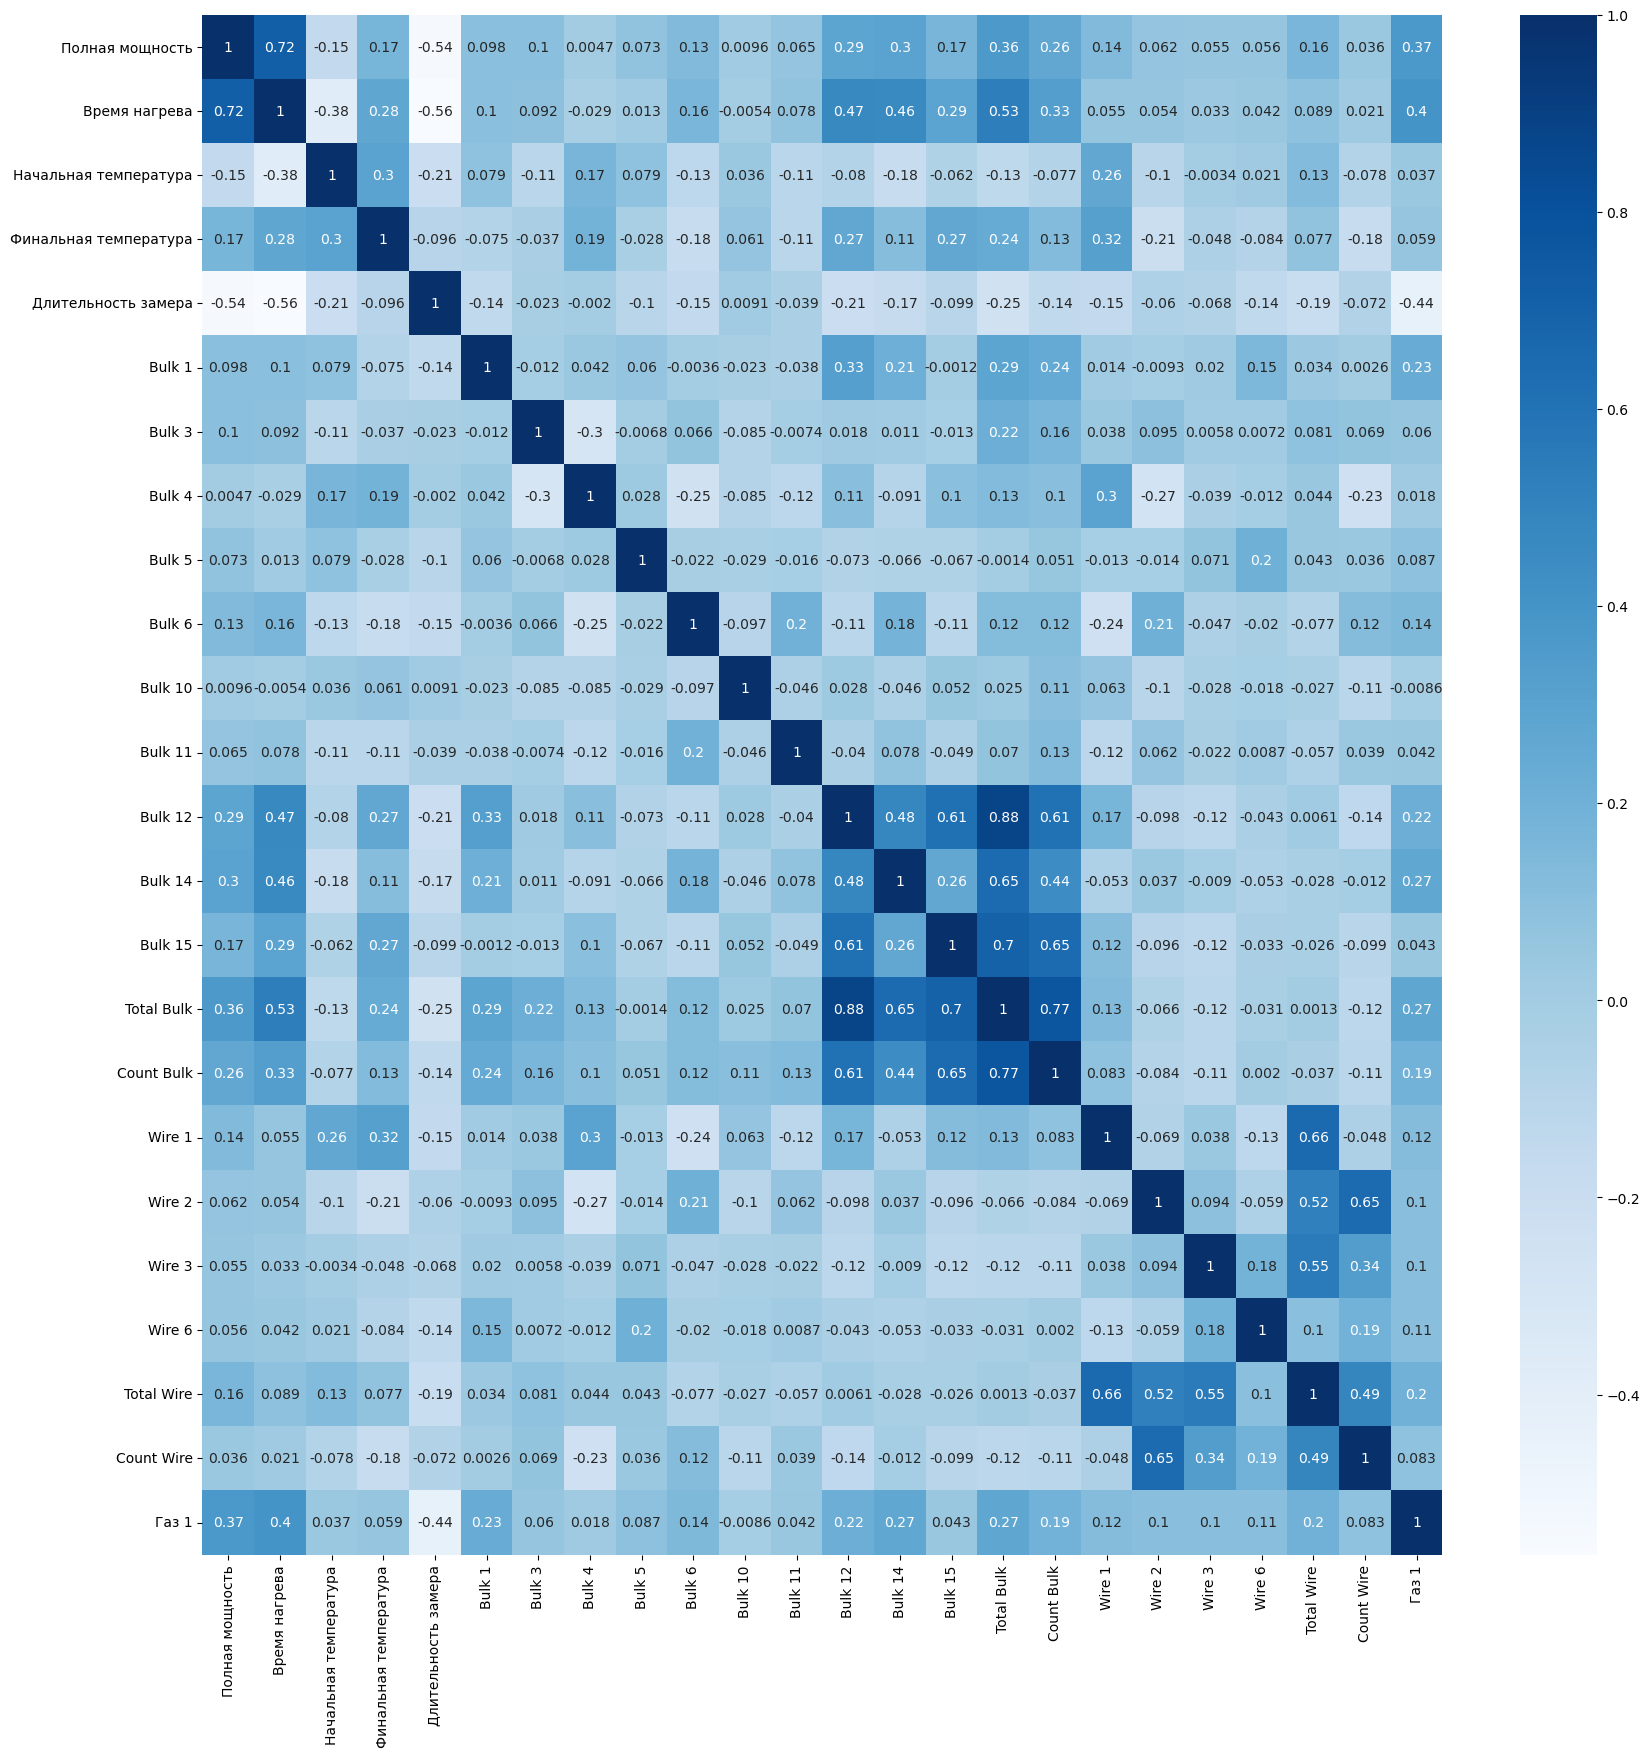

In [ ]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.show()

По матрице корреляции можно видеть:
* *`Полная мощность`* имеет:
  * <u>**Высокую связь**</u> с *`Время нагрева`*.
* *`Время нагрева`* имеет:
  * <u>**Заметную связь**</u> с *`Bulk 12_x`*, *`Bulk 14_x`* и *`Total Bulk`*.
* *`Начальная температура`* имеет:
  * <u>**Заметную связь**</u> с *`Финальная температура`*.
* *`Bulk 12_x`* имеет:
  * <u>**Высокую связь**</u> с *`Total Bulk`*.
  * <u>**Заметную связь**</u> с *`Bulk 14_x`*, *`Bulk 15_x`* и *`Count Bulk`*.  
* *`Bulk 14_x`* имеет:
  * <u>**Заметную связь**</u> с *`Total Bulk`* и *`Count Bulk`*.  
* *`Bulk 15_x`* имеет:
  * <u>**Заметную связь**</u> с *`Total Bulk`* и *`Count Bulk`*.  
* *`Total Bulk`* имеет:
  * <u>**Высокую связь**</u> с  *`Count Bulk`*.
  **`Wire 1_x`* имеет:
  * <u>**Заметную связь**</u> с *`Total Wire`*.  
* *`Wire 2_x`* имеет:
  * <u>**Заметную связь**</u> с *`Total Wire`* и *`Count Wire`*.  
* *`Wire 3_x`* имеет:
  * <u>**Заметную связь**</u> с *`Total Wire`*.  
  **`Total Wire`* имеет:
  * <u>**Заметную связь**</u> с *`Count Wire`*.  

**Мультиколлинеарность** при пороге в **0,9** между признаками <u>**отсутствует**</u>.

### Выводы по предобработке данных

* Из датафрейма **data_arc** удалена запись с отрицательной *Реактивной мощностью*
* Из имеющихся данных посчитаны новые признаки:
  * *Полная мощность*
  * *Время нагрева*
* Из датафрейма**data_temp** удалены записи с температурой менее 1400
* Из имеющихся данных сгруппированы записи с:
  * *Начальной температурой*
  * *Финальной температурой*
  * *Длительность замера*
* Из датафреймов **data_bulk** удалены признаки:
  * *Bulk 2*
  * *Bulk 7*
  * *Bulk 8*
  * *Bulk 9*
  * *Bulk 13*
* Из датафреймов **data_wire** удалены признаки:
  * *Wire 4*
  * *Wire 5*
  * *Wire 7*
  * *Wire 8*
  * *Wire 9*
* В датафреймах **data_bulk** и **data_wire** пропуски заменены значением 0
* Из имеющихся данных сформированы новые признаки:
  * *Total Bulk*
  * *Total Wire*
  * *Count Bulk*
  * *Count Wire*
* Датафреймы **data_bulk_time** и **data_wire_time** решено не использовать в обучении модели из-за большого количества пропусков, которые нечем заполнить
* Из всех датафреймов собран один общий датафрейм **df** по ключу *key*
* Для общего датафрейма проведён корреляционный анализ:
  * *`Полная мощность`* имеет:
    * <u>**Высокую связь**</u> с *`Время нагрева`*
  * *`Время нагрева`* имеет:
    * <u>**Заметную связь**</u> с *`Bulk 12_x`*, *`Bulk 14_x`* и *`Total Bulk`*
  * *`Начальная температура`* имеет:
    * <u>**Заметную связь**</u> с *`Финальная температура`*
  * *`Bulk 12_x`* имеет:
    * <u>**Высокую связь**</u> с *`Total Bulk`*
    * <u>**Заметную связь**</u> с *`Bulk 14_x`*, *`Bulk 15_x`* и *`Count Bulk`*
  * *`Bulk 14_x`* имеет:
    * <u>**Заметную связь**</u> с *`Total Bulk`* и *`Count Bulk`*
  * *`Bulk 15_x`* имеет:
    * <u>**Заметную связь**</u> с *`Total Bulk`* и *`Count Bulk`*
  * *`Total Bulk`* имеет:
    * <u>**Высокую связь**</u> с  *`Count Bulk`*
  *  **`Wire 1_x`* имеет:
    * <u>**Заметную связь**</u> с *`Total Wire`*
  * *`Wire 2_x`* имеет:
    * <u>**Заметную связь**</u> с *`Total Wire`* и *`Count Wire`*
  * *`Wire 3_x`* имеет:
    * <u>**Заметную связь**</u> с *`Total Wire`*
  * **`Total Wire`* имеет:
    * <u>**Заметную связь**</u> с *`Count Wire`*.
  * **Мультиколлинеарность** при пороге в **0,9** между признаками <u>**отсутствует**</u>

## Подготовка данных

In [ ]:
# Делим данные на выборки
X = df.drop('Финальная температура', axis=1)
y = df['Финальная температура']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=RANDOM_STATE)

In [ ]:
# Проверим размерность тренировочной выборки
X_train.shape[0]

1743

In [ ]:
# Проверим размерность тестовой выборки
X_test.shape[0]

581

## Обучение моделей


Обучим несколько моделей:
* **LinearRegression**
* **CatBoost**
* **LightGBM**

### LinearRegression

In [ ]:
# Создаём модель (всегда с константой!)
model_LR = LinearRegression(fit_intercept=True)

# Замеряем время обучения
start = time.time()
model_LR.fit(X_train, y_train)
end = time.time()
model_LR_train_time = end - start

# Замеряем время предсказания
start = time.time()
train_predictions_LR = model_LR.predict(X_train)
end = time.time()
model_LR_pred_time = end - start

# Оценка через кросс-валидацию
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
scores = cross_val_score(model_LR, X_train, y_train, cv=3, scoring=mae_scorer)
MAE_LR = -scores.mean()

print(f"MAE модели: {MAE_LR:.2f}")

MAE модели: 5.95


### CatBoost

In [ ]:
# Создаём словарь параметров
params = {
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3],
    'random_state': [RANDOM_STATE],
    'loss_function': ['MAE'],
    'early_stopping_rounds': [50]
}

# Создаём модель и подбираем гиперпараметры
model_Cat = CatBoostRegressor(verbose=0)
grid = GridSearchCV(
    estimator=model_Cat,
    param_grid=params,
    cv=KFold(n_splits=3),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

start = time.time()
grid.fit(X_train, y_train)
end = time.time()
best_model_Cat = grid.best_estimator_

# Сохраняем время обучения модели в переменную
model_CatBoost_train_time = end - start

# Замеряем время обучения
start = time.time()
train_predictions_CatBoost = best_model_Cat.predict(X_train)
end = time.time()
model_CatBoost_pred_time = end - start

# Считаем метрику MAE на тренировочной выборке
MAE_CatBoost = -grid.best_score_

print(f"Лучшие параметры: {grid.best_params_}")
print(f"MAE модели): {MAE_CatBoost:.2f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры: {'depth': 4, 'early_stopping_rounds': 50, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'loss_function': 'MAE', 'random_state': 250325}
MAE модели): 5.96


### LightGBM

In [ ]:
# Создаём словарь параметров
params = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.7, 0.9],
    'bagging_fraction': [0.7, 0.8]
}

# Задаём выборку для модели
train_data = Light.Dataset(X_train, y_train)

# Создаём модель и подбираем гиперпараметры
model_Light = Light.LGBMRegressor(objective='regression', metric='mae', verbose=-1)
grid = GridSearchCV(
    estimator=model_Light,
    param_grid=params,
    cv=KFold(n_splits=3),
    scoring='neg_mean_absolute_error',
    verbose=1
)

start = time.time()
grid.fit(X_train, y_train)
end = time.time()
best_model_Light = grid.best_estimator_

# Сохраняем время обучения модели в переменную
model_Light_train_time = end - start

# Замеряем время обучения
start = time.time()
train_predictions = best_model_Light.predict(X_train)
end = time.time()
model_Light_pred_time = end - start

# Считаем метрику MAE на тренировочной выборке
MAE_Light = -grid.best_score_

print(f"Лучшие параметры: {grid.best_params_}")
print(f"MAE модели: {MAE_Light:.2f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


  File "X:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "X:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "X:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "X:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Лучшие параметры: {'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'num_leaves': 31}
MAE модели: 6.07


## Выбор лучшей модели

### Охарактеризация всех моделей

In [ ]:
# Создадим датафрейм с характеристиками моделей
final_data = pd.DataFrame({'Модель': ['LinearRegression','CatBoost', 'LightGBM'],
                        'Время обучения(сек)': [model_LR_train_time, model_CatBoost_train_time, model_Light_train_time],
                        'Время предсказания(сек)': [model_LR_pred_time, model_CatBoost_pred_time, model_Light_pred_time],
                        'Значение метрики MAE': [MAE_LR, MAE_CatBoost, MAE_Light]})

### Выбор лучшей модели

In [ ]:
# Посмотрим на таблицу с характеристиками моделей
final_data

,Модель,Время обучения(сек),Время предсказания(сек),Значение метрики MAE
0,LinearRegression,0.013314,0.001006,5.950607
1,CatBoost,23.999152,0.002001,5.958089
2,LightGBM,2.682335,0.003000,6.065850


Cамой лучшей моделью выбрана **LinearRegression**, **метрика MAE** данной модели имеет значение **5.95**.

### Проверка лучшей модели на тестовой выборке

In [ ]:
# Проверяем модель на тестовой выборке
predictions_LR = model_LR.predict(X_test)

# Считаем метрику RMSE на тренировочной выборке
test_MAE_LR = mean_absolute_error(y_test, predictions_LR)

print("MAE модели: %.2f" % test_MAE_LR)

MAE модели: 6.11


**Модель LinearRegression полностью подходит под требования заказчика!**👍

### Анализ важности признаков

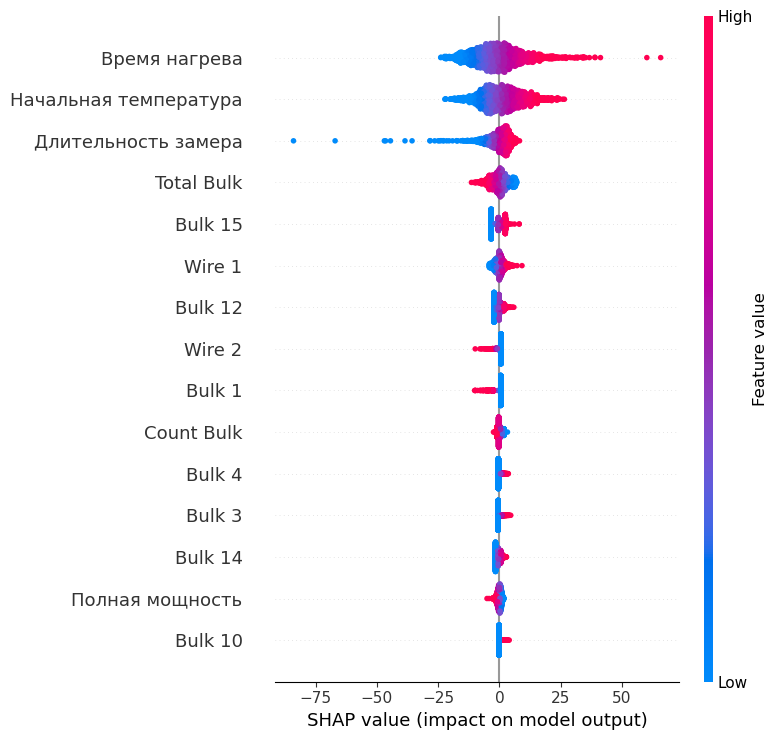

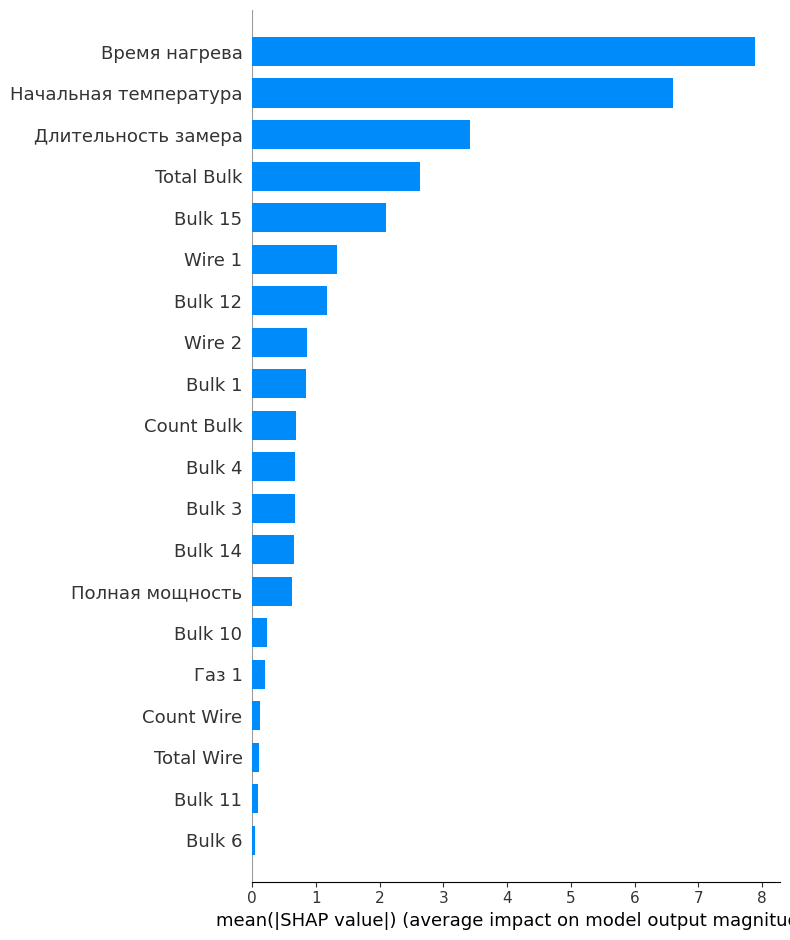

In [ ]:
# Построим  графики важности признаков
explainer = shap.LinearExplainer(model_LR, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=15)
shap.summary_plot(shap_values, X_train, plot_type='bar')

**Самые важные признаки:**
1. Время нагрева  
2. Начальная температура  
3. Длительность замера  
4. Total Bulk  
5. Bulk 15  
6. Wire 1  
    
**Интерпретация влияния признаков:**
* *Время нагрева*, *Начальная температура* и *Длительность замер*а оказывают наибольшее влияние на модель. Их высокие значения связаны с сильным положительным или отрицательным воздействием на целевую переменную (в зависимости от контекста данных).  
* *Total Bulk* и *Bulk 15* также значимы, но их влияние менее однородно: у некоторых наблюдений они увеличивают прогнозируемое значение, у других — уменьшают.  
* *Полная мощность* и *Bulk 10* демонстрируют отрицательную корреляцию с целевой переменной: чем выше их значения, тем ниже прогнозируемый показатель (отрицательные SHAP-значения).  
    
**Ключевые выводы:**
1. Положительное влияние:  
   * Признаки, связанные с временными параметрами (*Время нагрева*, *Длительность замера*), чаще увеличивают целевую переменную. Это может указывать на их критическую роль в процессе.  
   * *Total Bulk* и *Bulk 15* имеют неоднозначное влияние, но их присутствие в топе говорит о важности для модели.  

2. Отрицательное влияние:  
   * *Полная мощность* и *Bulk 10* снижают прогнозируемое значение. Возможно, их высокие значения связаны с неоптимальными режимами работы или перегрузками.  

3. Рекомендации:  
   * Уделить внимание контролю *Времени нагрева* и *Начальной температуры* — их стабильность может улучшить результат.  
   * Исследовать, почему *Полная мощность* и *Bulk 10* имеют негативный эффект: возможно, требуется корректировка параметров оборудования или режимов эксплуатации.  

## Общий вывод

Во время работы на дпроектом было сделано следующее:
* 1. **Загрузка и исследовательский анализ данных:**  
  * Найдены пропуски в некоторых датафреймах
  * Некоторые данные имеют неподходящий тип данных
  * Почти все датафреймы нуждаются в предобработке
  * По совету заказчика необходимо удалить выбросы в признаке *"Реактивная мощность"* датафрейма **data_arc** и признаке   *"Температура"* датафрейма **data_temp**
  * Выбросы в остальных признаках стоит проверить
* 2. **Предобработка и объединение данных:**  
  * Из датафрейма **data_arc** удалена запись с отрицательной *Реактивной мощностью*
  * Из имеющихся данных посчитаны новые признаки:
    * *Полная мощность*
    * *Время нагрева*
  * Из датафрейма **data_temp** удалены записи с температурой менее 1400
  * Из датафрейма **data_temp** удалены записи с пропусками
  * Из имеющихся данных сгруппированы записи с:
    * *Начальной температурой*
    * *Финальной температурой*
    * *Длительность замера*
  * Из датафреймов **data_bulk** удалены признаки:
    * *Bulk 2*
    * *Bulk 7*
    * *Bulk 8*
    * *Bulk 9*
    * *Bulk 13*
  * Из датафреймов **data_wire** удалены признаки:
    * *Wire 4*
    * *Wire 5*
    * *Wire 7*
    * *Wire 8*
    * *Wire 9*
  * В датафреймах **data_bulk** и **data_wire** пропуски заменены значением 0
  * Из имеющихся данных сформированы новые признаки:
    * *Total Bulk*
    * *Total Wire*
    * *Count Bulk*
    * *Count Wire*
  * Датафреймы **data_bulk_time** и **data_wire_time** решено не использовать в обучении модели из-за большого количества пропусков, которые нечем заполнить
  * Из всех датафреймов собран один общий датафрейм **df** по ключу *key*
* Для общего датафрейма проведён корреляционный анализ:
  * Некоторые признаки имеют **высокую и заметную связь* с другими признаками
  * **Мультиколлинеарность** при пороге в **0,9** между признаками <u>**отсутствует**</u>
* 3. **Подготовка данных:**  
  * Данные успешно разделены на тренировочную и тестовые выборки
* 4. **Обучение моделей:**  
  * Обучено несколько моделей:
    * **LinearRegression**
    * **CatBoost**
    * **LightGBM**
* 5. **Выбор лучшей модели:**  
  * Все модели охарактеризованы в одной таблице
  * Выбрана лучшая модель **LinearRegression**:
    * Метрика **MAE** на тренировочной выборке **5.95**
  * Лучшая модель проверена на тренировочной выборке:
    * **Метрика MAE на тестовой выборке равна 6.11**
  * Проведён анализ важности признаков    

**РЕКОМЕНДАЦИИ ДЛЯ ЗАКАЗЧИКА:**
   * Уделить внимание контролю *Времени нагрева* и *Начальной температуры* — их стабильность может улучшить результат.  
   * Исследовать, почему *Полная мощность* и *Bulk 10* имеют негативный эффект: возможно, требуется корректировка параметров оборудования или режимов эксплуатации.  